In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
# Analysis
import time
import warnings
from datetime import date, timedelta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import seaborn as sns

warnings.filterwarnings('ignore')

## Import Ngl with pyn_env active 
import Ngl


In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values
    hybm = DS.hybm.values
    hyai = DS.hyai.values
    hybi = DS.hybi.values

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS

In [5]:
def process_camData_highRes(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,3.0)

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS

## Read in SCAM data 

In [6]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

In [7]:
archiveDir = '/glade/scratch/mdfowler/archive/'

dateStrings = ['0609', '0923', '0715']
yearStrings = ['2016', '2017', '2017']
multiplVer  = ['V3',     'V4',   'V2']


for iDay in range(len(dateStrings)):

    case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens'+yearStrings[iDay]+'_start'+dateStrings[iDay]+'_pert00/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_start'+dateStrings[iDay]+'_pert00/',
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult5_start'+dateStrings[iDay]+'_pert00/', 
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult10_start'+dateStrings[iDay]+'_pert00/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_start'+dateStrings[iDay]+yearStrings[iDay]+'/',    #LES-based multipliers
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_c7eq0p75_start'+dateStrings[iDay]+yearStrings[iDay]+'/',    #C7 + LES-based multipliers
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers250km_start'+dateStrings[iDay]+yearStrings[iDay]+'v2/',    #LES-based multipliers
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers250km_start'+dateStrings[iDay]+yearStrings[iDay]+'v2_setFluxes/',    #LES-based multipliers, set sfcFluxes
                ]


    # caseMult_names = ['HMG','HTG*01','HTG*05','HTG*10','HTG*LESvals','HTG*LESvals_c7eq0p75']
    caseMult_names = ['HMG','HTG*01','HTG*LESvals100','HTG*LESvals250','HTG*LESvals250_setFluxes']

    for iCase in range(len(case_mult)): 
        ## Get list of input files 
        listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
        listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
        listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))

        ## Should only be one file per glob above (ran for two days), so just open each DS here
        iFile = 0 
        with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
            multDS         = cesm_correct_time(multDS)
            multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

        with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
            clm_multDS['time'] = multDS['time']



        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
            varMult['time'] = multDS['time']

            multDS = xr.merge([multDS, varMult])

        ## Select the second simulated day for analysis 
        iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                     (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]

        multDS      = multDS.isel(time=iTimeStart_day2)
        clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)

        ## Give case attribute and combine 
        multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
        clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

        if iCase==0: 
            multDS_allCases     = multDS
            clm_multDS_allCases = clm_multDS
        else:
            multDS_allCases     = xr.concat([multDS_allCases,     multDS], "case")
            clm_multDS_allCases = xr.concat([clm_multDS_allCases, clm_multDS], "case")

        del multDS,clm_multDS

        print('Read in '+caseMult_names[iCase]+' case')
        
    if iDay==0:
        multDS_allDays     = multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        clm_multDS_allDays = clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        
    else: 
        multDS_allDays     = xr.concat([multDS_allDays,     multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        clm_multDS_allDays = xr.concat([clm_multDS_allDays, clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        
    print('Done with the day: %s %s' % (yearStrings[iDay], dateStrings[iDay]))

Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals100 case
Read in HTG*LESvals250 case
Read in HTG*LESvals250_setFluxes case
Done with the day: 2016 0609
Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals100 case
Read in HTG*LESvals250 case
Read in HTG*LESvals250_setFluxes case
Done with the day: 2017 0923
Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals100 case
Read in HTG*LESvals250 case
Read in HTG*LESvals250_setFluxes case
Done with the day: 2017 0715


In [8]:
## Convert to local times...
# - - - - - - - - - - - - - - 
multDS_allDays_local    = multDS_allDays.copy(deep=True)
clm_multDS_allDays_local= clm_multDS_allDays.copy(deep=True)

# Compute local time 
localTimes = multDS_allDays['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
multDS_allDays_local    = multDS_allDays_local.assign_coords({"time": localTimes})
clm_multDS_allDays_local= clm_multDS_allDays_local.assign_coords({"time": localTimes})

In [9]:
## Multiplier cases too 

for iDay in range(len(dateStrings)):
    for iCase in range(len(caseMult_names)):
        
        selTime = np.where((multDS_allDays_local['time.year']==int(yearStrings[iDay])) & 
                           (multDS_allDays_local['time.month']==int(dateStrings[iDay][0:2])) )[0]
        
        sel_mult = process_camData( multDS_allDays_local.sel(case=caseMult_names[iCase],
                                                           strDate=multDS_allDays_local.strDate.values[iDay]).isel(time=selTime) )

        if iCase==0: 
            mult_all = sel_mult
        else:
            mult_all = xr.concat([mult_all, sel_mult], "case")

        del sel_mult
        
    if iDay==0: 
        days_all = mult_all
    else:
        days_all = xr.concat([days_all, mult_all], "strDate")
    del mult_all
    print('Done with day %i of %i' % (iDay+1, len(dateStrings) ) )

Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Done with day 1 of 3
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Done with day 2 of 3
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Done with day 3 of 3


In [10]:
days_all_20170716 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==7))[0]).sel(strDate='2017_0715')
days_all_20160610 = days_all.isel(time=np.where( (days_all['time.year']==2016) & (days_all['time.month']==6))[0]).sel(strDate='2016_0609')
days_all_20170924 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==9))[0]).sel(strDate='2017_0923')

#### Try a high-res version 

In [14]:
archiveDir = '/glade/scratch/mdfowler/archive/'

dateStrings = ['0609']
yearStrings = ['2016']
multiplVer  = ['V3'  ]


for iDay in range(len(dateStrings)):
   # FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_256L_start06092016
   # FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_256L_LESmultipliersV3_start06092016

    case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_256L_start'+dateStrings[iDay]+yearStrings[iDay]+'/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_256L_start'+dateStrings[iDay]+yearStrings[iDay]+'/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_256L_LESmultipliers'+multiplVer[iDay]+'_start'+dateStrings[iDay]+yearStrings[iDay]+'/',    #LES-based multipliers
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_c7eq0p75_start'+dateStrings[iDay]+yearStrings[iDay]+'/',    #C7 + LES-based multipliers
                ]

    caseMult_names = ['HMG','HTG*01','HTG*LESvals']

    for iCase in range(len(case_mult)): 
        ## Get list of input files 
        listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
        listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
        listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))

        ## Should only be one file per glob above (ran for two days), so just open each DS here
        iFile = 0 
        with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
            multDS         = cesm_correct_time(multDS)
            multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

        with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
            clm_multDS['time'] = multDS['time']



        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
            varMult['time'] = multDS['time']

            multDS = xr.merge([multDS, varMult])

        ## Select the second simulated day for analysis 
        iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                     (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]

        multDS      = multDS.isel(time=iTimeStart_day2)
        clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)

        ## Give case attribute and combine 
        multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
        clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

        if iCase==0: 
            multDS_allCases     = multDS
            clm_multDS_allCases = clm_multDS
        else:
            multDS_allCases     = xr.concat([multDS_allCases,     multDS], "case")
            clm_multDS_allCases = xr.concat([clm_multDS_allCases, clm_multDS], "case")

        del multDS,clm_multDS

        print('Read in '+caseMult_names[iCase]+' case')
        
    if iDay==0:
        multDS_allDays     = multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        clm_multDS_allDays = clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        
    else: 
        multDS_allDays     = xr.concat([multDS_allDays,     multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        clm_multDS_allDays = xr.concat([clm_multDS_allDays, clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        
    print('Done with the day: %s %s' % (yearStrings[iDay], dateStrings[iDay]))

Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals case
Done with the day: 2016 0609


In [ ]:
## Convert to local times...
# - - - - - - - - - - - - - - 
multDS_allDays_local    = multDS_allDays.copy(deep=True)
clm_multDS_allDays_local= clm_multDS_allDays.copy(deep=True)

# Compute local time 
localTimes = multDS_allDays['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
multDS_allDays_local    = multDS_allDays_local.assign_coords({"time": localTimes})
clm_multDS_allDays_local= clm_multDS_allDays_local.assign_coords({"time": localTimes})

In [ ]:
## highRes case too 

for iCase in range(len(caseMult_names)):

    sel_mult = process_camData_highRes( multDS_allDays_local.sel(case=caseMult_names[iCase]) )

    if iCase==0: 
        mult_all_highRes = sel_mult
    else:
        mult_all_highRes = xr.concat([mult_all_highRes, sel_mult], "case")

    del sel_mult

In [ ]:
days_allHighRes_20160610 = mult_all_highRes

## Read in LES data

**From Jason:**<br>
Files ending in _00.nc are heterogeneous cases, _01.nc are homogeneous.

These come with two caveats.  First, I made these just merging netCDF output files as they exist in the run directories.  Due to sloppy job management on my end, a lot of these jobs output a few timesteps before running out of allocation and were then restarted at a time before that final output.  Point being, there's some duplicate time entries that I didn't trim out, so you'll have to pay a little attention to the timestamps.

Second, I made these by hand so it's not impossible that one or more of these is missing a chunk of output, so again you'll have to pay a little attention to the timestamps.  If you find any gaps let me know and I'll fill them.

**100 m resolution:**

In [14]:
# lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/'
# # lesDir = '/glade/scratch/mdfowler/CLASP_LESoutput/'

# lesDateStrings = ['20170716', '20160610', '20170924']

# for iDay in range(len(lesDateStrings)): 

#     HTGds = xr.open_dataset(lesDir+'megmoments_'+lesDateStrings[iDay]+'_00.nc', decode_times=False)
#     HMGds = xr.open_dataset(lesDir+'megmoments_'+lesDateStrings[iDay]+'_01.nc', decode_times=False)

#     HTGds = HTGds.set_index(Time='XTIME').assign_coords({"case": 'HTG'})
#     HMGds = HMGds.set_index(Time='XTIME').assign_coords({"case": 'HMG'})
    
#     ## Find indices to keep for HTG DS
#     keepInds_HTG = []
#     uniqueHTG    = np.unique(HTGds.Time.values)

#     for iHTG in range(len(uniqueHTG)): 
#         dateVals = np.where(HTGds.Time.values==uniqueHTG[iHTG])[0]

#         if len(dateVals)<2: 
#             keepInds_HTG = np.append(keepInds_HTG, dateVals)
#         else: 
#             # print('dateVals = ', dateVals)
#             # print('Keeping ', dateVals[-1])
#             keepInds_HTG = np.append(keepInds_HTG, dateVals[-1])

#     ## Find indices to keep for HMG DS
#     keepInds_HMG = []
#     uniqueHMG    = np.unique(HMGds.Time.values)

#     for iHMG in range(len(uniqueHMG)): 
#         dateVals = np.where(HMGds.Time.values==uniqueHMG[iHMG])[0]

#         if len(dateVals)<2: 
#             keepInds_HMG = np.append(keepInds_HMG, dateVals)
#         else: 
#             keepInds_HMG = np.append(keepInds_HMG, dateVals[-1])

#     ## Now keep only the non-duplicated times 
#     HMGds = HMGds.isel(Time=keepInds_HMG.astype(int))
#     HTGds = HTGds.isel(Time=keepInds_HTG.astype(int))

    
#     LES_allCases = xr.concat([HMGds, HTGds], "case")
    
#     if lesDateStrings[iDay]=='20170716':
#         LES_allCases_20170716 = LES_allCases
#     elif lesDateStrings[iDay]=='20160610':
#         LES_allCases_20160610 = LES_allCases
#     elif lesDateStrings[iDay]=='20170924':
#         LES_allCases_20170924 = LES_allCases

**250 m resolution:**

In [11]:
lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/allDays_250mRes/'
# lesDir = '/glade/scratch/mdfowler/CLASP_LESoutput/'

lesDateStrings = ['20160610', '20170716', '20170924']

for iDay in range(len(lesDateStrings)): 

    HTGds = xr.open_dataset(lesDir+'trimfr2_'+lesDateStrings[iDay]+'_00.nc', decode_times=False)
    HMGds = xr.open_dataset(lesDir+'trimfr2_'+lesDateStrings[iDay]+'_01.nc', decode_times=False)

    HTGds = HTGds.assign_coords({"case": 'HTG'})
    HMGds = HMGds.assign_coords({"case": 'HMG'})
    
#     ## Find indices to keep for HTG DS
#     keepInds_HTG = []
#     uniqueHTG    = np.unique(HTGds.Time.values)

#     for iHTG in range(len(uniqueHTG)): 
#         dateVals = np.where(HTGds.Time.values==uniqueHTG[iHTG])[0]

#         if len(dateVals)<2: 
#             keepInds_HTG = np.append(keepInds_HTG, dateVals)
#         else: 
#             # print('dateVals = ', dateVals)
#             # print('Keeping ', dateVals[-1])
#             keepInds_HTG = np.append(keepInds_HTG, dateVals[-1])

#     ## Find indices to keep for HMG DS
#     keepInds_HMG = []
#     uniqueHMG    = np.unique(HMGds.Time.values)

#     for iHMG in range(len(uniqueHMG)): 
#         dateVals = np.where(HMGds.Time.values==uniqueHMG[iHMG])[0]

#         if len(dateVals)<2: 
#             keepInds_HMG = np.append(keepInds_HMG, dateVals)
#         else: 
#             keepInds_HMG = np.append(keepInds_HMG, dateVals[-1])

#     ## Now keep only the non-duplicated times 
#     HMGds = HMGds.isel(Time=keepInds_HMG.astype(int))
#     HTGds = HTGds.isel(Time=keepInds_HTG.astype(int))

    
    LES_allCases = xr.concat([HMGds, HTGds], "case")
    
    if lesDateStrings[iDay]=='20170712':
        LES_allCases_20170712 = LES_allCases
    elif lesDateStrings[iDay]=='20160819':
        LES_allCases_20160819 = LES_allCases
    elif lesDateStrings[iDay]=='20160720':
        LES_allCases_20160720 = LES_allCases
        
    elif lesDateStrings[iDay]=='20170716':
        LES_allCases_20170716 = LES_allCases
    elif lesDateStrings[iDay]=='20160610':
        LES_allCases_20160610 = LES_allCases
    elif lesDateStrings[iDay]=='20170924':
        LES_allCases_20170924 = LES_allCases
        
    else:
        print(' !! This day not ready to be defined !! ')
        
    print('Done with reading in ', lesDateStrings[iDay])

Done with reading in  20160610
Done with reading in  20170716
Done with reading in  20170924


**Get some default LES data too**

In [12]:
# lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/defaultOutput/chaney-web-00.egr.duke.edu/CLASP/LES/diags/'
lesDir = '/glade/scratch/mdfowler/CLASP_LESoutput/defaultOutput/chaney-web-00.egr.duke.edu/CLASP/LES/diags/'


for iDay in range(len(lesDateStrings)):

    HMGdir = lesDir+'doz_'+lesDateStrings[iDay]+'_01/'
    HTGdir = lesDir+'doz_'+lesDateStrings[iDay]+'_00/'

    listFilesHMG = np.sort(glob.glob(HMGdir+'diag_d01*'))
    listFilesHTG = np.sort(glob.glob(HTGdir+'diag_d01*'))

    for iFileHMG in range(len(listFilesHMG)): 
        dsHMG = xr.open_dataset(listFilesHMG[iFileHMG], decode_times=False)
        dsHMG = dsHMG.set_index(Time='XTIME').assign_coords({"case": 'HMG'})

        if iFileHMG==0:
            HMGds_lesDay = dsHMG 
        else: 
            HMGds_lesDay = xr.concat([HMGds_lesDay, dsHMG], dim='Time')

    for iFileHTG in range(len(listFilesHTG)): 
        dsHTG = xr.open_dataset(listFilesHTG[iFileHTG], decode_times=False)
        dsHTG = dsHTG.set_index(Time='XTIME').assign_coords({"case": 'HTG'})

        if iFileHTG==0:
            HTGds_lesDay = dsHTG 
        else: 
            HTGds_lesDay = xr.concat([HTGds_lesDay, dsHTG], dim='Time')


    LES_allCasesDefault = xr.concat([HMGds_lesDay, HTGds_lesDay], "case")
    
    if lesDateStrings[iDay]=='20170716':
        LES_allCasesDefault_20170716 = LES_allCasesDefault
    elif lesDateStrings[iDay]=='20160610':
        LES_allCasesDefault_20160610 = LES_allCasesDefault
    elif lesDateStrings[iDay]=='20170924':
        LES_allCasesDefault_20170924 = LES_allCasesDefault
        
    print('Done with reading in ', lesDateStrings[iDay])
        

Done with reading in  20160610
Done with reading in  20170716
Done with reading in  20170924


**Fix time arrays**

In [13]:
startTime_20170716   = datetime.datetime(2017,7,16, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST

times_20170716 = [] 
for iT in range(len(LES_allCasesDefault_20170716.Time.values)): 
    timeStep       = startTime_20170716+timedelta(minutes = int(LES_allCasesDefault_20170716.Time.values[iT]))
    times_20170716 = np.append(times_20170716, timeStep)
    
LES_allCasesDefault_20170716['datetime'] = (('Time'), times_20170716)
LES_allCasesDefault_20170716             = LES_allCasesDefault_20170716.set_index(Time='datetime')

# ## Do the same for the moments array
# timesMoments_20170716 = [] 
# for iT in range(len(LES_allCases_20170716.Time.values)): 
#     timeStep2       = startTime_20170716+timedelta(minutes = int(LES_allCases_20170716.Time.values[iT]))
#     timesMoments_20170716 = np.append(timesMoments_20170716, timeStep2)

# LES_allCases_20170716['datetime'] = (('Time'), timesMoments_20170716)
# LES_allCases_20170716             = LES_allCases_20170716.set_index(Time='datetime')

In [14]:
startTime_20160610   = datetime.datetime(2016,6,10, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST

times_20160610 = [] 
for iT in range(len(LES_allCasesDefault_20160610.Time.values)): 
    timeStep       = startTime_20160610+timedelta(minutes = int(LES_allCasesDefault_20160610.Time.values[iT]))
    times_20160610 = np.append(times_20160610, timeStep)
    
LES_allCasesDefault_20160610['datetime'] = (('Time'), times_20160610)
LES_allCasesDefault_20160610             = LES_allCasesDefault_20160610.set_index(Time='datetime')

# ## Do the same for the moments array
# timesMoments_20160610 = [] 
# for iT in range(len(LES_allCases_20170716.Time.values)): 
#     timeStep2             = startTime_20160610+timedelta(minutes = int(LES_allCases_20160610.Time.values[iT]))
#     timesMoments_20160610 = np.append(timesMoments_20160610, timeStep2)

# LES_allCases_20160610['datetime'] = (('Time'), timesMoments_20160610)
# LES_allCases_20160610             = LES_allCases_20160610.set_index(Time='datetime')

In [15]:
startTime_20170924   = datetime.datetime(2017,9,24, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST

times_20170924 = [] 
for iT in range(len(LES_allCasesDefault_20170924.Time.values)): 
    timeStep       = startTime_20170924+timedelta(minutes = int(LES_allCasesDefault_20170924.Time.values[iT]))
    times_20170924 = np.append(times_20170924, timeStep)
    
LES_allCasesDefault_20170924['datetime'] = (('Time'), times_20170924)
LES_allCasesDefault_20170924             = LES_allCasesDefault_20170924.set_index(Time='datetime')

# ## Do the same for the moments array
# timesMoments_20170924 = [] 
# for iT in range(len(LES_allCases_20170924.Time.values)): 
#     timeStep2             = startTime_20170924+timedelta(minutes = int(LES_allCases_20170924.Time.values[iT]))
#     timesMoments_20170924 = np.append(timesMoments_20170924, timeStep2)

# LES_allCases_20170924['datetime'] = (('Time'), timesMoments_20170924)
# LES_allCases_20170924             = LES_allCases_20170924.set_index(Time='datetime')

In [16]:
## Fix time arrays to be useful in the LES cases
startTime = datetime.datetime(2016,1,1, 0,0,0)


times_20170716 = [] 
for iT in range(len(LES_allCases_20170716.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20170716.time.values[iT]))
    times_20170716 = np.append(times_20170716, timeStep)
LES_allCases_20170716['datetime'] = (('time'), times_20170716)
LES_allCases_20170716             = LES_allCases_20170716.set_index(time='datetime')

times_20160610 = [] 
for iT in range(len(LES_allCases_20160610.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20160610.time.values[iT]))
    times_20160610 = np.append(times_20160610, timeStep)
LES_allCases_20160610['datetime'] = (('time'), times_20160610)
LES_allCases_20160610             = LES_allCases_20160610.set_index(time='datetime')

times_20170924 = [] 
for iT in range(len(LES_allCases_20170924.time.values)): 
    timeStep       = startTime+timedelta(minutes = int(LES_allCases_20170924.time.values[iT]))
    times_20170924 = np.append(times_20170924, timeStep)
LES_allCases_20170924['datetime'] = (('time'), times_20170924)
LES_allCases_20170924             = LES_allCases_20170924.set_index(time='datetime')





In [17]:
## Above is not yet in local time...

# Compute local time 
localTimes1 = LES_allCases_20170716['time'].values - np.timedelta64(5,'h')
localTimes2 = LES_allCases_20160610['time'].values - np.timedelta64(5,'h')
localTimes3 = LES_allCases_20170924['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
LES_allCases_20170716    = LES_allCases_20170716.assign_coords({"time": localTimes1})
LES_allCases_20160610    = LES_allCases_20160610.assign_coords({"time": localTimes2})
LES_allCases_20170924    = LES_allCases_20170924.assign_coords({"time": localTimes3})


In [18]:
## These use the right variable names for the 100m resolution
# hourlyMeanZ_20170924     = LES_allCases_20170924.CSP_Z.resample(Time='1H').mean()
# hourlyMeanZstag_20170924 = LES_allCases_20170924.CSP_Z8W.resample(Time='1H').mean()

# hourlyMeanZ_20170716     = LES_allCases_20170716.CSP_Z.resample(Time='1H').mean()
# hourlyMeanZstag_20170716 = LES_allCases_20170716.CSP_Z8W.resample(Time='1H').mean()

# hourlyMeanZ_20160610     = LES_allCases_20160610.CSP_Z.resample(Time='1H').mean()
# hourlyMeanZstag_20160610 = LES_allCases_20160610.CSP_Z8W.resample(Time='1H').mean()

# np.shape(hourlyMeanZ_20170924.sel(case='HMG'))

## These use the right variable names for the 250m resolution
hourlyMeanZ_20170924     = LES_allCases_20170924.z.resample(time='1H').mean()
hourlyMeanZstag_20170924 = LES_allCases_20170924.zw.resample(time='1H').mean()

hourlyMeanZ_20170716     = LES_allCases_20170716.z.resample(time='1H').mean()
hourlyMeanZstag_20170716 = LES_allCases_20170716.zw.resample(time='1H').mean()

hourlyMeanZ_20160610     = LES_allCases_20160610.z.resample(time='1H').mean()
hourlyMeanZstag_20160610 = LES_allCases_20160610.zw.resample(time='1H').mean()

np.shape(hourlyMeanZ_20170924.sel(case='HMG'))



(16, 226)

**Potentially useful table?**

In [52]:
def printInfo(LESds, LESvar, LESunitsAdjust, 
              CAMds, CAMvar, dateString):
    
    print('-----------\n',str(CAMds['time.month'].values[0])+'/'+str(CAMds['time.day'].values[0])+'/'+str(CAMds['time.year'].values[0]),'\n-----------')
    print(LESvar)
    print('  Daily max (LES):    %8.3f' % (np.nanmax(LESds[LESvar].sel(case='HTG').values[:,0])*LESunitsAdjust ))
    print(CAMvar)
    print('  Daily max (SCAM):   %8.3f' % (np.nanmax(CAMds[CAMvar].sel(case='HTG*01').isel(ilev=-1).values-CAMds[CAMvar].sel(case='HMG').isel(ilev=-1).values)) )
    print('Suggested multiplier: %8.2f' % ((np.nanmax(LESds[LESvar].sel(case='HTG').values[:,0])*LESunitsAdjust )/(np.nanmax(CAMds[CAMvar].sel(case='HTG*01').isel(ilev=-1).values-CAMds[CAMvar].sel(case='HMG').isel(ilev=-1).values))) )
    
    return

In [40]:

# printInfo(LES_allCases_20160610, 'CSP_THL2', 1.0, 
printInfo(LES_allCases_20160610, 'thl2', 1.0, 
          days_all_20160610, 'THLP2_CLUBB', '20160610')

# printInfo(LES_allCases_20170716, 'CSP_THL2', 1.0, 
printInfo(LES_allCases_20170716, 'thl2', 1.0, 
          days_all_20170716, 'THLP2_CLUBB', '20170716')

# printInfo(LES_allCases_20170924, 'CSP_THL2', 1.0, 
printInfo(LES_allCases_20170924, 'thl2', 1.0, 
          days_all_20170924, 'THLP2_CLUBB', '20170924')



-----------
 6/10/2016 
-----------
thl2
  Daily max (LES):       0.541
THLP2_CLUBB
  Daily max (SCAM):      0.109
Suggested multiplier:     4.97
-----------
 7/16/2017 
-----------
thl2
  Daily max (LES):       1.681
THLP2_CLUBB
  Daily max (SCAM):      0.109
Suggested multiplier:    15.39
-----------
 9/24/2017 
-----------
thl2
  Daily max (LES):       0.690
THLP2_CLUBB
  Daily max (SCAM):      0.025
Suggested multiplier:    27.99


In [53]:

# printInfo(LES_allCases_20160610, 'CSP_QV2', 1e6, 
printInfo(LES_allCases_20160610, 'qv2', 1e6, 
          days_all_20160610, 'RTP2_CLUBB', '20160610')

# printInfo(LES_allCases_20170716, 'CSP_QV2', 1e6, 
printInfo(LES_allCases_20170716, 'qv2', 1e6, 
          days_all_20170716, 'RTP2_CLUBB', '20170716')

# printInfo(LES_allCases_20170924, 'CSP_QV2', 1e6, 
printInfo(LES_allCases_20170924, 'qv2', 1e6, 
          days_all_20170924, 'RTP2_CLUBB', '20170924')



-----------
 6/10/2016 
-----------
qv2
  Daily max (LES):       0.175
RTP2_CLUBB
  Daily max (SCAM):      0.210
Suggested multiplier:     0.83
-----------
 7/16/2017 
-----------
qv2
  Daily max (LES):       3.764
RTP2_CLUBB
  Daily max (SCAM):      0.494
Suggested multiplier:     7.62
-----------
 9/24/2017 
-----------
qv2
  Daily max (LES):       0.117
RTP2_CLUBB
  Daily max (SCAM):      0.086
Suggested multiplier:     1.36


In [87]:

print('   DailyMax         6/10/2016        7/16/2017        9/24/2017')
print('                   ----------       ----------       -----------')
print('thlp2 (HTG_LES):  %12.3f %12.3f %16.3f' % (np.nanmax(LES_allCases_20160610.CSP_THL2.sel(case='HTG').values[:,0]),
                                            np.nanmax(LES_allCases_20170716.CSP_THL2.sel(case='HTG').values[:,0]),
                                            np.nanmax(LES_allCases_20170924.CSP_THL2.sel(case='HTG').values[:,0]) ) )

print('thlp2 (HTG_SCAM): %12.3f %12.3f %16.3f' % (np.nanmax(days_all_20160610.THLP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values-days_all_20160610.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                 np.nanmax(days_all_20170716.THLP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values-days_all_20170716.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                 np.nanmax(days_all_20170924.THLP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values-days_all_20170924.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)) )

print('Factor applied in SCAM:    *%i          *%i              *%i' % (10,20,95))
print('thlp2 (HTGmult_SCAM): %8.3f %12.3f %16.3f' % (np.nanmax(days_all_20160610.THLP2_CLUBB.sel(case='HTG*LESvals').isel(ilev=-1).values-days_all_20160610.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                    np.nanmax(days_all_20170716.THLP2_CLUBB.sel(case='HTG*LESvals').isel(ilev=-1).values-days_all_20170716.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                    np.nanmax(days_all_20170924.THLP2_CLUBB.sel(case='HTG*LESvals').isel(ilev=-1).values-days_all_20170924.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)) )

   DailyMax         6/10/2016        7/16/2017        9/24/2017
                   ----------       ----------       -----------
thlp2 (HTG_LES):         0.988        1.963            2.350
thlp2 (HTG_SCAM):        0.109        0.109            0.025
Factor applied in SCAM:    *10          *20              *95
thlp2 (HTGmult_SCAM):    1.079        1.844            2.300


In [19]:

print('   DailyMax         6/10/2016        7/16/2017        9/24/2017')
print('                   ----------       ----------       -----------')
print('qv2 (HTG_LES):   %12.3f %12.3f %16.3f' % (np.nanmax(LES_allCases_20160610.CSP_QV2.sel(case='HTG').values[:,0])*1e6,
                                            np.nanmax(LES_allCases_20170716.CSP_QV2.sel(case='HTG').values[:,0])*1e6,
                                            np.nanmax(LES_allCases_20170924.CSP_QV2.sel(case='HTG').values[:,0])*1e6 ) )

print('rtp2 (HTG_SCAM): %12.3f %12.3f %16.3f' % (np.nanmax(days_all_20160610.RTP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - days_all_20160610.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                 np.nanmax(days_all_20170716.RTP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - days_all_20170716.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                 np.nanmax(days_all_20170924.RTP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - days_all_20170924.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)) )

print('Factor applied in SCAM:    *%i          *%i              *%i' % (1,15,3))
print('rtp2 (HTGmult_SCAM): %8.3f %12.3f %16.3f' % (np.nanmax(days_all_20160610.RTP2_CLUBB.sel(case='HTG*LESvals').isel(ilev=-1).values - days_all_20160610.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                    np.nanmax(days_all_20170716.RTP2_CLUBB.sel(case='HTG*LESvals').isel(ilev=-1).values - days_all_20170716.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
                                                    np.nanmax(days_all_20170924.RTP2_CLUBB.sel(case='HTG*LESvals').isel(ilev=-1).values - days_all_20170924.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)) )

   DailyMax         6/10/2016        7/16/2017        9/24/2017
                   ----------       ----------       -----------
qv2 (HTG_LES):          0.221        5.522            0.230
rtp2 (HTG_SCAM):        0.210        0.494            0.086
Factor applied in SCAM:    *1          *15              *3
rtp2 (HTGmult_SCAM):    0.208        5.518            0.257


## Look at some plots!

In [19]:
def plotLES_timeHeight(pltVar, pltDS, zVals, cmapSel='viridis', ymax=10000,
                       cbarFormat=None, cbarMax=None, cbarMin=None):
    
    ## Control intervals used in contouring
    if cbarMax==None:
        levSelMax  = np.nanpercentile(pltDS[pltVar], 99) 
    else: 
        levSelMax  = cbarMax 
        
    if cbarMin==None:
        levSelMin  = np.nanpercentile(pltDS[pltVar], 10) 
    else: 
        levSelMin = cbarMin 
    levC       = np.arange(levSelMin, levSelMax, (levSelMax-levSelMin)/100)


    fig,axs = plt.subplots(1,3, figsize=(20,7))
    axs     = axs.ravel()

    ## Plot raw values (HMG, HTG) 
    axs[0].contourf(pltDS.sel(case='HMG')['Time'].values, 
                    zVals.sel(case='HMG').mean(dim='Time'), 
                    pltDS.sel(case='HMG')[pltVar].values.transpose(),
                    levC, cmap=cmapSel, extend='both')

    cplt = axs[1].contourf(pltDS.sel(case='HTG')['Time'].values, 
                        zVals.sel(case='HTG').mean(dim='Time'),
                        pltDS.sel(case='HTG')[pltVar].values.transpose(),
                        levC, cmap=cmapSel, extend='both')
    
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units, format=cbarFormat)
    cbar.ax.tick_params(labelsize=12) 

    axs[0].set_title('HMG: '+pltDS[pltVar].description)
    axs[1].set_title('HTG')
    
    ## Plot difference too
    testDS = pltDS.sel(case='HTG')[pltVar].values
    ctrlDS = pltDS.sel(case='HMG')[pltVar].values
    diffDS = testDS - ctrlDS
    levsMaxDiff = np.nanpercentile(diffDS, 95) 
    levsMinDiff = np.nanpercentile(diffDS, 5) 
    levsEvenDiff = np.nanmax([np.abs(levsMaxDiff), np.abs(levsMinDiff)])
    cstep        = (2*levsEvenDiff)/100
    levsCdiff    = np.arange(-levsEvenDiff, levsEvenDiff+cstep, cstep)
    
    cplt2 = axs[2].contourf(pltDS.sel(case='HTG')['Time'].values, 
                        zVals.sel(case='HTG').mean(dim='Time'),
                        diffDS.transpose(),
                        levsCdiff, cmap='bwr', extend='both')
    
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units, format=cbarFormat)
    cbar.ax.tick_params(labelsize=12) 

    axs[2].set_title('HTG-HMG') 

    # # Use meaningful x-labels
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(7))
    axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
    axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
    axs[2].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))


    axs[0].set_ylim([0,ymax])
    axs[1].set_ylim([0,ymax])
    axs[2].set_ylim([0,ymax])

    
#     axs[0].set_xlim([pltDS.Time.values[0]+np.timedelta64(2,'h'), 
#                      pltDS.Time.values[0]+np.timedelta64(6,'h')] )

#     axs[1].set_xlim([pltDS.Time.values[0]+np.timedelta64(2,'h'), 
#                      pltDS.Time.values[0]+np.timedelta64(6,'h')] )
    
#     axs[2].set_xlim([pltDS.Time.values[0]+np.timedelta64(2,'h'), 
#                      pltDS.Time.values[0]+np.timedelta64(6,'h')] )
    

    return

In [20]:
def plotSCAM_timeHeight(pltVar, pltDS, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='viridis', ymax=750, ymin=1000,
                        cbarFormat=None, cbarMax=None, cbarMin=None,
                        unitsString=''):
    
    ## Control intervals used in contouring
    if cbarMax==None:
        levSelMax  = np.nanpercentile([pltDS[pltVar].sel(case=case1), pltDS[pltVar].sel(case=case2)], 99) 
    else: 
        levSelMax  = cbarMax 
        
    if cbarMin==None:
        levSelMin  = np.nanpercentile([pltDS[pltVar].sel(case=case1), pltDS[pltVar].sel(case=case2)], 10) 
    else: 
        levSelMin = cbarMin 
    levC       = np.arange(levSelMin, levSelMax+(levSelMax-levSelMin)/100, (levSelMax-levSelMin)/100)

    ## Get string for y-axis to be plotted 
    if np.shape(pltDS[pltVar])[2]==64:
        levString = 'lev'
    elif np.shape(pltDS[pltVar])[2]==78:
        levString = 'levInterp'
    elif np.shape(pltDS[pltVar])[2]==65:
        levString = 'ilev'
    
    ## Set up the plot
    fig,axs = plt.subplots(1,3, figsize=(20,7))
    axs     = axs.ravel()

    if pltVar=='OMEGA_interp': 
        pltValues1 = np.squeeze(pltDS.sel(case=case1)[pltVar].values) * 0.01 * 3600.0 ## Convert from Pa/s to mb/hr
        pltValues2 = np.squeeze(pltDS.sel(case=case2)[pltVar].values) * 0.01 * 3600.0 ## Convert from Pa/s to mb/hr
    elif pltVar=='RTP2_CLUBB_interp':
        pltValues1 = np.squeeze(pltDS.sel(case=case1)[pltVar].values) * 1e-6 ## Convert from g2/kg2 to kg2/kg2
        pltValues2 = np.squeeze(pltDS.sel(case=case2)[pltVar].values) * 1e-6 ## Convert from g2/kg2 to kg2/kg2
    else: 
        pltValues1 = np.squeeze(pltDS.sel(case=case1)[pltVar].values)
        pltValues2 = np.squeeze(pltDS.sel(case=case2)[pltVar].values) 
        
    

    ## Plot raw values 
    axs[0].contourf(pltDS.sel(case=case1)['time'].values, 
                    pltDS.sel(case=case1)[levString].values, 
                    pltValues1.transpose(),
                    levC, cmap=cmapSel, extend='both')

    cplt = axs[1].contourf(pltDS.sel(case=case2)['time'].values, 
                        pltDS.sel(case=case2)[levString].values,
                        pltValues2.transpose(),
                        levC, cmap=cmapSel, extend='both')
    axs[0].set_title(case1+': '+pltVar)
    axs[1].set_title(case2)
    
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=unitsString, format=cbarFormat)
    cbar.ax.tick_params(labelsize=12) 
    
    ## Plot difference too 
    diffDS = pltValues2 - pltValues1
    levsMaxDiff = np.nanpercentile(diffDS, 95) 
    levsMinDiff = np.nanpercentile(diffDS, 5) 
    levsEvenDiff = np.nanmax([np.abs(levsMaxDiff), np.abs(levsMinDiff)])
    cstep        = (2*levsEvenDiff)/100
    levsCdiff    = np.arange(-levsEvenDiff, levsEvenDiff+cstep, cstep)
    
    cplt2 = axs[2].contourf(pltDS.sel(case=case2)['time'].values, 
                        pltDS.sel(case=case2)[levString].values,
                        diffDS.transpose(),
                        levsCdiff, cmap='bwr', extend='both')
    axs[2].set_title(case2+' - '+case1)

    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax, label=unitsString, format=cbarFormat)
    cbar.ax.tick_params(labelsize=12) 

    # # Use meaningful x-labels
    axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
    axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
    axs[2].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
    

    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    axs[2].invert_yaxis()
    
    axs[0].set_ylim([ymin,ymax])
    axs[1].set_ylim([ymin,ymax])
    axs[2].set_ylim([ymin,ymax])
 
    axs[0].set_xlim([pltDS.time.values[18], pltDS.time.values[26]])
    axs[1].set_xlim([pltDS.time.values[18], pltDS.time.values[26]])
    axs[2].set_xlim([pltDS.time.values[18], pltDS.time.values[26]])
    
    return

In [19]:
# plotSCAM_timeHeight('Q_interp', days_all_20160610, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='Blues', ymax=500,ymin=950,
#                         cbarFormat='%.3f', cbarMax=0.014, cbarMin=0.0,
#                         unitsString=multDS_allCases.Q.units)

# plotSCAM_timeHeight('Q_interp', days_all_20170716, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='Blues', ymax=500,ymin=950,
#                         cbarFormat='%.3f', cbarMax=0.0165, cbarMin=0.0,
#                         unitsString=multDS_allCases.Q.units)

# plotSCAM_timeHeight('Q_interp', days_all_20170924, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='Blues', ymax=500,ymin=950,
#                         cbarFormat='%.3f', cbarMax=0.013, cbarMin=0.0,
#                         unitsString=multDS_allCases.Q.units)

In [20]:
# plotLES_timeHeight('AVP_QV', LES_allCasesDefault_20160610, hourlyMeanZ_20160610,
#                    cmapSel='Blues', ymax=6000, cbarFormat='%.3f', cbarMax=0.014, cbarMin=0.0,)

# plotLES_timeHeight('AVP_QV', LES_allCasesDefault_20170716, hourlyMeanZ_20170716, 
#                    cmapSel='Blues', ymax=6000, cbarFormat='%.3f', cbarMax=0.0165, cbarMin=0.0)

# plotLES_timeHeight('AVP_QV', LES_allCasesDefault_20170924, hourlyMeanZ_20170924,
#                    cmapSel='Blues', ymax=6000, cbarFormat='%.3f', cbarMax=0.013, cbarMin=0.0)

In [21]:
# plotLES_timeHeight('AVP_QC', LES_allCasesDefault_20160610, hourlyMeanZ_20160610, 
#                    cmapSel='Blues', ymax=7500)

# plotLES_timeHeight('AVP_QC', LES_allCasesDefault_20170716, hourlyMeanZ_20170716, 
#                    cmapSel='Blues', ymax=7500)

# plotLES_timeHeight('AVP_QC', LES_allCasesDefault_20170924, hourlyMeanZ_20170924, 
#                    cmapSel='Blues', ymax=7500)

In [22]:
# plotLES_timeHeight('AVP_LWC', LES_allCasesDefault_20160610, hourlyMeanZ_20160610, 
#                    cmapSel='Purples', ymax=7500)

# plotLES_timeHeight('AVP_LWC', LES_allCasesDefault_20170716, hourlyMeanZ_20170716, 
#                    cmapSel='Purples', ymax=7500)

# plotLES_timeHeight('AVP_LWC', LES_allCasesDefault_20170924, hourlyMeanZ_20170924, 
#                    cmapSel='Purples', ymax=7500)

In [ ]:
## Plot HTG-HMG difference per day at a selected hour 

pltVar = 'AVS_SH'
hrSel = 14

htg_20160610 = LES_allCasesDefault_20160610.sel(case='HTG').isel(time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
hmg_20160610 = LES_allCasesDefault_20160610.sel(case='HMG').isel(time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
diff_20160610 = htg_20160610 - hmg_20160610


htg_20170716 = LES_allCasesDefault_20170716.sel(case='HTG').isel(time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
hmg_20170716 = LES_allCasesDefault_20170716.sel(case='HMG').isel(time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
diff_20170716 = htg_20170716 - hmg_20170716

htg_20170924 = LES_allCasesDefault_20170924.sel(case='HTG').isel(time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
hmg_20170924 = LES_allCasesDefault_20170924.sel(case='HMG').isel(time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
diff_20170924 = htg_20170924 - hmg_20170924


## Plot options 
fig,axs = plt.subplots(1,3, figsize=(20,7))
axs     = axs.ravel()
levsDiff = np.arange(-50,51,1) 

axs[0].contourf(diff_20160610.sel(case='HMG')['Time'].values, 
                zVals.sel(case='HMG').mean(dim='Time'), 
                diff_20160610[pltVar].values.transpose(),
                levC, cmap=cmapSel, extend='both')

cplt = axs[1].contourf(pltDS.sel(case='HTG')['Time'].values, 
                    zVals.sel(case='HTG').mean(dim='Time'),
                    pltDS.sel(case='HTG')[pltVar].values.transpose(),
                    levC, cmap=cmapSel, extend='both')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units, format=cbarFormat)
cbar.ax.tick_params(labelsize=12)

In [23]:
# plotLES_timeHeight('CSP_UW', LES_allCases_20160610, hourlyMeanZ_20160610, 
#                    cmapSel='viridis',  cbarMax=None, cbarMin=None,
#                    ymax=7500)

# plotLES_timeHeight('CSP_UW', LES_allCases_20170716, hourlyMeanZ_20170716, 
#                    cmapSel='viridis', cbarMax=None, cbarMin=None,
#                    ymax=7500)

# plotLES_timeHeight('CSP_UW', LES_allCases_20170924, hourlyMeanZ_20170924, 
#                    cmapSel='viridis', cbarMax=None, cbarMin=None,
#                    ymax=7500)

In [24]:
# plotLES_timeHeight('CSP_VW', LES_allCases_20160610, hourlyMeanZ_20160610, 
#                    cmapSel='viridis',  cbarMax=None, cbarMin=None,
#                    ymax=7500)

# plotLES_timeHeight('CSP_VW', LES_allCases_20170716, hourlyMeanZ_20170716, 
#                    cmapSel='viridis', cbarMax=None, cbarMin=None,
#                    ymax=7500)

# plotLES_timeHeight('CSP_VW', LES_allCases_20170924, hourlyMeanZ_20170924, 
#                    cmapSel='viridis', cbarMax=None, cbarMin=None,
#                    ymax=7500)

**CLUBB's moments**

In [25]:
# plotLES_timeHeight('CSP_THL2', LES_allCases_20160610, hourlyMeanZ_20160610, 
#                    cmapSel='viridis', cbarMax=0.45, cbarMin=0.00,
#                    ymax=7500)

# # plotLES_timeHeight('CSP_THL2', LES_allCases_20170716, hourlyMeanZ_20170716, 
# #                    cmapSel='viridis', cbarMax=0.5,
# #                    ymax=7500)

# plotLES_timeHeight('CSP_THL2', LES_allCases_20170924, hourlyMeanZ_20170924, 
#                    cmapSel='viridis', cbarMax=0.25, cbarMin=0.00,
#                    ymax=7500)

In [26]:
# plotSCAM_timeHeight('THLP2_CLUBB_interp', days_all_20160610, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='viridis', ymax=500,ymin=950,
#                         cbarFormat='%.3f', cbarMax=0.12, cbarMin=0.00,
#                         unitsString=multDS_allCases.THLP2_CLUBB.units)

# # plotSCAM_timeHeight('THLP2_CLUBB_interp', days_all_20170716, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
# #                         cmapSel='viridis', ymax=500,ymin=950,
# #                         cbarFormat='%.3f', 
# #                         unitsString=multDS_allCases.THLP2_CLUBB.units)

# plotSCAM_timeHeight('THLP2_CLUBB_interp', days_all_20170924, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='viridis', ymax=500,ymin=950,
#                         cbarFormat='%.3f',  cbarMax=0.08, cbarMin=0.00,
#                         unitsString=multDS_allCases.THLP2_CLUBB.units)

In [27]:
# plotLES_timeHeight('CSP_QV2', LES_allCases_20160610, hourlyMeanZ_20160610, 
#                    cmapSel='viridis', 
#                    ymax=7500)

# # plotLES_timeHeight('CSP_QV2', LES_allCases_20170716, hourlyMeanZ_20170716, 
# #                    cmapSel='viridis', 
# #                    ymax=7500)

# plotLES_timeHeight('CSP_QV2', LES_allCases_20170924, hourlyMeanZ_20170924, 
#                    cmapSel='viridis',  cbarMax=1.0e-6, cbarMin=0.00,
#                    ymax=7500)

In [28]:
# plotSCAM_timeHeight('RTP2_CLUBB_interp', days_all_20160610, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='viridis', ymax=500,ymin=950,
#                         cbarFormat=None, cbarMax=0.5e-6, cbarMin=0.0,
#                         unitsString='kg^2/kg^2')

# # plotSCAM_timeHeight('RTP2_CLUBB_interp', days_all_20170716, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
# #                         cmapSel='viridis', ymax=500,ymin=950,
# #                         cbarFormat=None, cbarMax=0.5e-6, cbarMin=0.0,
# #                         unitsString='kg^2/kg^2')

# plotSCAM_timeHeight('RTP2_CLUBB_interp', days_all_20170924, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
#                         cmapSel='viridis', ymax=500,ymin=950,
#                         cbarFormat=None, cbarMax=0.15e-6, cbarMin=0.0,
#                         unitsString='kg^2/kg^2')

### Diurnal cycles

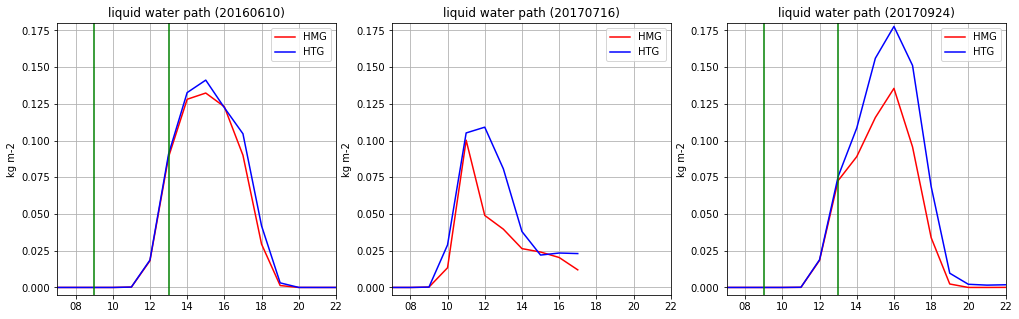

In [18]:
fig,axs = plt.subplots(1,3, figsize=(17,5))
axs = axs.ravel()

pltVar = 'AVT_LWP'

axs[0].plot(LES_allCasesDefault_20160610.Time.values, 
            LES_allCasesDefault_20160610.sel(case='HMG')[pltVar].values, 'r', label='HMG')
axs[0].plot(LES_allCasesDefault_20160610.Time.values, 
            LES_allCasesDefault_20160610.sel(case='HTG')[pltVar].values, 'b', label='HTG')
axs[0].set_title(LES_allCasesDefault_20160610[pltVar].description+ ' (20160610)')
axs[0].legend()
axs[0].set_ylabel(LES_allCasesDefault_20160610[pltVar].units)
# axs[0].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))



axs[1].plot(LES_allCasesDefault_20170716.Time.values, 
            LES_allCasesDefault_20170716.sel(case='HMG')[pltVar].values, 'r', label='HMG')
axs[1].plot(LES_allCasesDefault_20170716.Time.values, 
            LES_allCasesDefault_20170716.sel(case='HTG')[pltVar].values, 'b', label='HTG')
axs[1].set_title(LES_allCasesDefault_20170716[pltVar].description+ ' (20170716)')
axs[1].legend()
axs[1].set_ylabel(LES_allCasesDefault_20170716[pltVar].units)
# axs[1].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))



axs[2].plot(LES_allCasesDefault_20170924.Time.values, 
            LES_allCasesDefault_20170924.sel(case='HMG')[pltVar].values, 'r', label='HMG')
axs[2].plot(LES_allCasesDefault_20170924.Time.values, 
            LES_allCasesDefault_20170924.sel(case='HTG')[pltVar].values, 'b', label='HTG')
axs[2].set_title(LES_allCasesDefault_20170924[pltVar].description+ ' (20170924)')
axs[2].legend()
axs[2].set_ylabel(LES_allCasesDefault_20170924[pltVar].units)
# axs[2].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([-0.005, 0.18])
axs[1].set_ylim([-0.005, 0.18])
axs[2].set_ylim([-0.005, 0.18])

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_xlim([LES_allCasesDefault_20160610.Time.values[0], LES_allCasesDefault_20160610.Time.values[0]+np.timedelta64(15,'h') ])
axs[1].set_xlim([LES_allCasesDefault_20170716.Time.values[0], LES_allCasesDefault_20170716.Time.values[0]+np.timedelta64(15,'h') ])
axs[2].set_xlim([LES_allCasesDefault_20170924.Time.values[0], LES_allCasesDefault_20170924.Time.values[0]+np.timedelta64(15,'h') ])

axs[0].axvline(LES_allCasesDefault_20160610.Time.values[0]+np.timedelta64(2,'h'), color='green')
axs[0].axvline(LES_allCasesDefault_20160610.Time.values[0]+np.timedelta64(6,'h'), color='green')
axs[2].axvline(LES_allCasesDefault_20170924.Time.values[0]+np.timedelta64(2,'h'), color='green')
axs[2].axvline(LES_allCasesDefault_20170924.Time.values[0]+np.timedelta64(6,'h'), color='green')

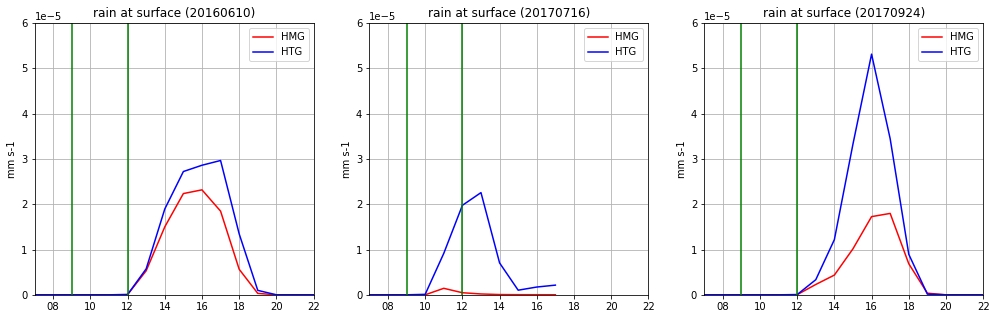

In [19]:
fig,axs = plt.subplots(1,3, figsize=(17,5))
axs = axs.ravel()

pltVar = 'AVS_RAIN'

axs[0].plot(LES_allCasesDefault_20160610.Time.values, 
            LES_allCasesDefault_20160610.sel(case='HMG')[pltVar].mean(dim='south_north').mean(dim='west_east').values, 'r', label='HMG')
axs[0].plot(LES_allCasesDefault_20160610.Time.values, 
            LES_allCasesDefault_20160610.sel(case='HTG')[pltVar].mean(dim='south_north').mean(dim='west_east').values, 'b', label='HTG')
axs[0].set_title(LES_allCasesDefault_20160610[pltVar].description+ ' (20160610)')
axs[0].legend()
axs[0].set_ylabel(LES_allCasesDefault_20160610[pltVar].units)
# axs[0].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))



axs[1].plot(LES_allCasesDefault_20170716.Time.values, 
            LES_allCasesDefault_20170716.sel(case='HMG')[pltVar].mean(dim='south_north').mean(dim='west_east').values, 'r', label='HMG')
axs[1].plot(LES_allCasesDefault_20170716.Time.values, 
            LES_allCasesDefault_20170716.sel(case='HTG')[pltVar].mean(dim='south_north').mean(dim='west_east').values, 'b', label='HTG')
axs[1].set_title(LES_allCasesDefault_20170716[pltVar].description+ ' (20170716)')
axs[1].legend()
axs[1].set_ylabel(LES_allCasesDefault_20170716[pltVar].units)
# axs[1].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))



axs[2].plot(LES_allCasesDefault_20170924.Time.values, 
            LES_allCasesDefault_20170924.sel(case='HMG')[pltVar].mean(dim='south_north').mean(dim='west_east').values, 'r', label='HMG')
axs[2].plot(LES_allCasesDefault_20170924.Time.values, 
            LES_allCasesDefault_20170924.sel(case='HTG')[pltVar].mean(dim='south_north').mean(dim='west_east').values, 'b', label='HTG')
axs[2].set_title(LES_allCasesDefault_20170924[pltVar].description+ ' (20170924)')
axs[2].legend()
axs[2].set_ylabel(LES_allCasesDefault_20170924[pltVar].units)
# axs[2].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([0, 6e-5])
axs[1].set_ylim([0, 6e-5])
axs[2].set_ylim([0, 6e-5])

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_xlim([LES_allCasesDefault_20160610.Time.values[0], LES_allCasesDefault_20160610.Time.values[0]+np.timedelta64(15,'h') ])
axs[1].set_xlim([LES_allCasesDefault_20170716.Time.values[0], LES_allCasesDefault_20170716.Time.values[0]+np.timedelta64(15,'h') ])
axs[2].set_xlim([LES_allCasesDefault_20170924.Time.values[0], LES_allCasesDefault_20170924.Time.values[0]+np.timedelta64(15,'h') ])

axs[0].axvline(LES_allCasesDefault_20160610.Time.values[0]+np.timedelta64(2,'h'), color='green')
axs[0].axvline(LES_allCasesDefault_20160610.Time.values[0]+np.timedelta64(5,'h'), color='green')
axs[1].axvline(LES_allCasesDefault_20170716.Time.values[0]+np.timedelta64(2,'h'), color='green')
axs[1].axvline(LES_allCasesDefault_20170716.Time.values[0]+np.timedelta64(5,'h'), color='green')
axs[2].axvline(LES_allCasesDefault_20170924.Time.values[0]+np.timedelta64(2,'h'), color='green')
axs[2].axvline(LES_allCasesDefault_20170924.Time.values[0]+np.timedelta64(5,'h'), color='green')

In [19]:
LESshflx_20160610 = np.nanmean(np.nanmean(LES_allCasesDefault_20160610.AVS_SH.sel(case='HMG'),axis=1), axis=1)
LESshflx_20170716 = np.nanmean(np.nanmean(LES_allCasesDefault_20170716.AVS_SH.sel(case='HMG'),axis=1), axis=1)
LESshflx_20170924 = np.nanmean(np.nanmean(LES_allCasesDefault_20170924.AVS_SH.sel(case='HMG'),axis=1), axis=1)

LESlhflx_20160610 = np.nanmean(np.nanmean(LES_allCasesDefault_20160610.AVS_LH.sel(case='HMG'),axis=1), axis=1)
LESlhflx_20170716 = np.nanmean(np.nanmean(LES_allCasesDefault_20170716.AVS_LH.sel(case='HMG'),axis=1), axis=1)
LESlhflx_20170924 = np.nanmean(np.nanmean(LES_allCasesDefault_20170924.AVS_LH.sel(case='HMG'),axis=1), axis=1)





(17433.291666666668, 17433.916666666668)

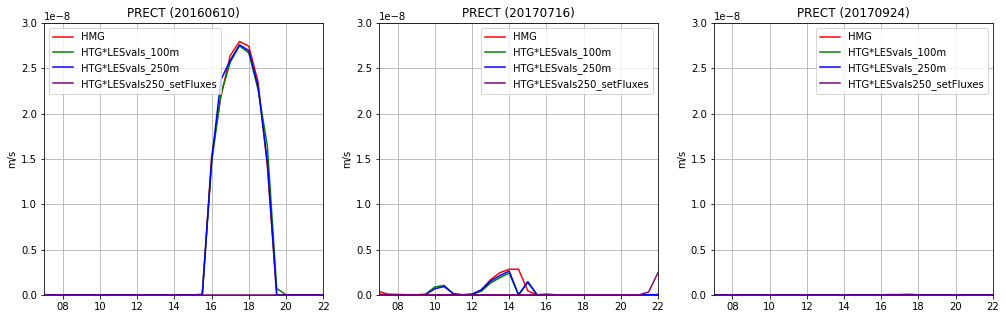

In [23]:
fig,axs = plt.subplots(1,3, figsize=(17,5))
axs = axs.ravel()

pltVar = 'PRECT'

axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HMG')[pltVar].values), 'r', label='HMG')
axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HTG*LESvals100')[pltVar].values), 'g', label='HTG*LESvals_100m')
axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HTG*LESvals250')[pltVar].values), 'b', label='HTG*LESvals_250m')
axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HTG*LESvals250_setFluxes')[pltVar].values), color='purple', label='HTG*LESvals250_setFluxes')
axs[0].set_title(pltVar+ ' (20160610)')
axs[0].legend()
axs[0].set_ylabel(multDS_allCases[pltVar].units)
# axs[0].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))



axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HMG')[pltVar].values), 'r', label='HMG')
axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HTG*LESvals100')[pltVar].values), 'g', label='HTG*LESvals_100m')
axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HTG*LESvals250')[pltVar].values), 'b', label='HTG*LESvals_250m')
axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HTG*LESvals250_setFluxes')[pltVar].values), color='purple', label='HTG*LESvals250_setFluxes')
axs[1].set_title(pltVar+ ' (20170716)')
axs[1].legend()
axs[1].set_ylabel(multDS_allCases[pltVar].units)
# axs[1].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))


axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HMG')[pltVar].values), 'r', label='HMG')
axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HTG*LESvals100')[pltVar].values), 'g', label='HTG*LESvals_100m')
axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HTG*LESvals250')[pltVar].values), 'b', label='HTG*LESvals_250m')
axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HTG*LESvals250_setFluxes')[pltVar].values), color='purple', label='HTG*LESvals250_setFluxes')
axs[2].set_title(pltVar+ ' (20170924)')
axs[2].legend()
axs[2].set_ylabel(multDS_allCases[pltVar].units)
# axs[2].xaxis.set_major_locator(plt.MaxNLocator(6))
# axs[2].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([0, 3e-8])
axs[1].set_ylim([0, 3e-8])
axs[2].set_ylim([0, 3e-8])

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_xlim([days_all_20160610.time.values[14], days_all_20160610.time.values[0]+np.timedelta64(22,'h') ])
axs[1].set_xlim([days_all_20170716.time.values[14], days_all_20170716.time.values[0]+np.timedelta64(22,'h') ])
axs[2].set_xlim([days_all_20170924.time.values[14], days_all_20170924.time.values[0]+np.timedelta64(22,'h') ])

(17433.291666666668, 17433.916666666668)

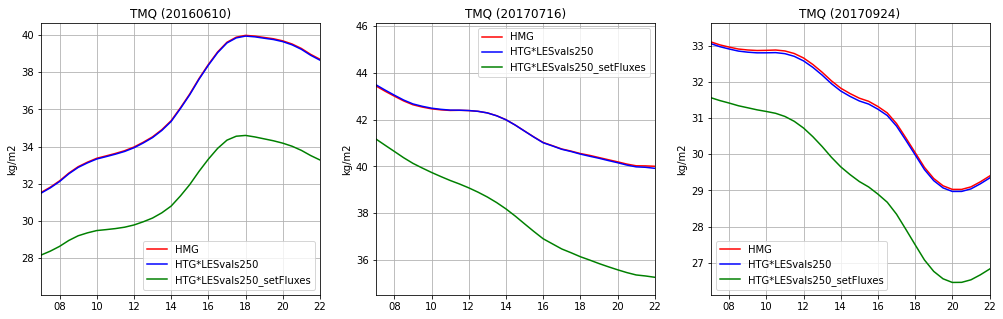

In [29]:
fig,axs = plt.subplots(1,3, figsize=(17,5))
axs = axs.ravel()

# pltVar = 'TGCLDLWP'
pltVar = 'TMQ'

axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HMG')[pltVar].values), 'r', label='HMG')
# axs[0].plot(days_all_20160610.time.values, 
#             np.squeeze(days_all_20160610.sel(case='HTG*01')[pltVar].values), color='purple', label='HTG*01')
# axs[0].plot(days_all_20160610.time.values, 
#             np.squeeze(days_all_20160610.sel(case='HTG*10')[pltVar].values), color='orange', label='HTG*10')
axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HTG*LESvals250')[pltVar].values), 'b', label='HTG*LESvals250')
axs[0].plot(days_all_20160610.time.values, 
            np.squeeze(days_all_20160610.sel(case='HTG*LESvals250_setFluxes')[pltVar].values), 'g', label='HTG*LESvals250_setFluxes')
# axs[0].plot(days_all_20160610.time.values, 
#             np.squeeze(days_all_20160610.sel(case='HTG*LESvals_c7eq0p75')[pltVar].values), 'b', label='HTG*LESvals_c7eq0p75')
axs[0].set_title(pltVar+ ' (20160610)')
axs[0].legend()
axs[0].set_ylabel(multDS_allCases[pltVar].units)
axs[0].xaxis.set_major_formatter(DateFormatter("%H"))


axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HMG')[pltVar].values), 'r', label='HMG')
axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HTG*LESvals250')[pltVar].values), 'b', label='HTG*LESvals250')
axs[1].plot(days_all_20170716.time.values, 
            np.squeeze(days_all_20170716.sel(case='HTG*LESvals250_setFluxes')[pltVar].values), 'g', label='HTG*LESvals250_setFluxes')
# axs[1].plot(days_all_20170716.time.values, 
#             np.squeeze(days_all_20170716.sel(case='HTG*LESvals_c7eq0p75')[pltVar].values), 'b', label='HTG*LESvals_c7eq0p75')
axs[1].set_title(pltVar+ ' (20170716)')
axs[1].legend()
axs[1].set_ylabel(multDS_allCases[pltVar].units)
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))


axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HMG')[pltVar].values), 'r', label='HMG')
axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HTG*LESvals250')[pltVar].values), 'b', label='HTG*LESvals250')
axs[2].plot(days_all_20170924.time.values, 
            np.squeeze(days_all_20170924.sel(case='HTG*LESvals250_setFluxes')[pltVar].values), 'g', label='HTG*LESvals250_setFluxes')
# axs[2].plot(days_all_20170924.time.values, 
#             np.squeeze(days_all_20170924.sel(case='HTG*LESvals_c7eq0p75')[pltVar].values), 'b', label='HTG*LESvals_c7eq0p75')
axs[2].set_title(pltVar+ ' (20170924)')
axs[2].legend()
axs[2].set_ylabel(multDS_allCases[pltVar].units)
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

# axs[0].set_ylim([0, 0.11])
# axs[1].set_ylim([0, 0.11])
# axs[2].set_ylim([0, 0.11])

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[0].set_xlim([days_all_20160610.time.values[14], days_all_20160610.time.values[0]+np.timedelta64(22,'h') ])
axs[1].set_xlim([days_all_20170716.time.values[14], days_all_20170716.time.values[0]+np.timedelta64(22,'h') ])
axs[2].set_xlim([days_all_20170924.time.values[14], days_all_20170924.time.values[0]+np.timedelta64(22,'h') ])

In [24]:
multDS_allDays.TMQ.long_name

'Total (vertically integrated) precipitable water'

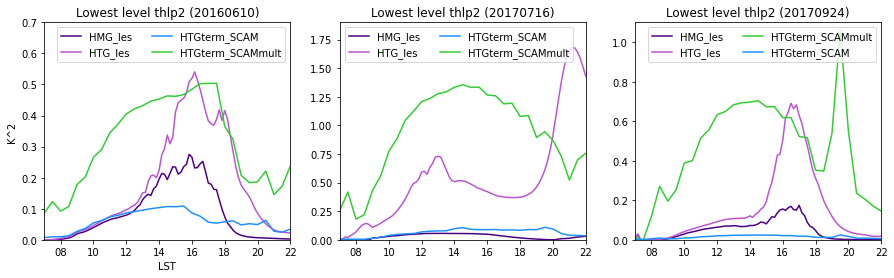

In [33]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = 0

axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.thl2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.thl2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.THLP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - 
                       days_all_20160610.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
            color='dodgerblue', 
            label='HTGterm_SCAM')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.THLP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values - 
                       days_all_20160610.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
            color='limegreen', 
            label='HTGterm_SCAMmult')
axs[0].legend(ncol=2)
axs[0].set_title('Lowest level thlp2 (20160610)')
axs[0].set_xlim([LES_allCases_20160610.time.values[0], LES_allCases_20160610.time.values[-1]])
axs[0].set_ylabel('K^2')
axs[0].set_xlabel('LST')


axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.thl2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.thl2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.THLP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - 
                       days_all_20170716.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
            color='dodgerblue', 
            label='HTGterm_SCAM')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.THLP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values - 
                       days_all_20170716.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
            color='limegreen', 
            label='HTGterm_SCAMmult')
axs[1].legend(ncol=2)
axs[1].set_title('Lowest level thlp2 (20170716)')
axs[1].set_xlim([LES_allCases_20170716.time.values[0], LES_allCases_20170716.time.values[-1]])



axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.thl2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.thl2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.THLP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values - 
                       days_all_20170924.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
            color='limegreen', 
            label='HTGterm_SCAMmult')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.THLP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - 
                       days_all_20170924.THLP2_CLUBB.sel(case='HMG').isel(ilev=-1).values),
            color='dodgerblue', 
            label='HTGterm_SCAM')
axs[2].legend(ncol=2)
axs[2].set_title('Lowest level thlp2 (20170924)')
axs[2].set_xlim([LES_allCases_20170924.time.values[0], LES_allCases_20170924.time.values[-1]])


# axs[0].grid()
# axs[1].grid()
# axs[2].grid()

axs[0].set_ylim([0, 0.7])
axs[1].set_ylim([0, 1.9])
axs[2].set_ylim([0, 1.1])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


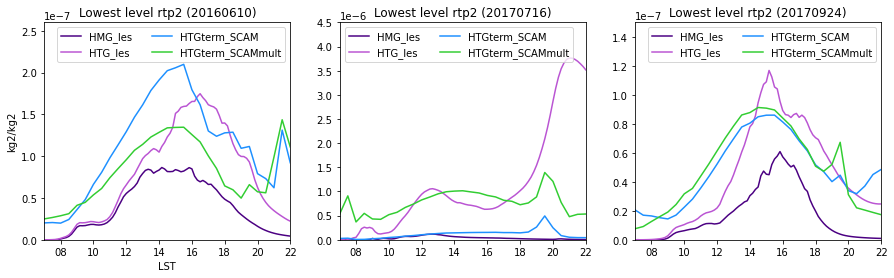

In [34]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = 0

axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.qv2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.qv2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.RTP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - 
                       days_all_20160610.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='dodgerblue', 
            label='HTGterm_SCAM')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.RTP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values - 
                       days_all_20160610.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='limegreen', 
            label='HTGterm_SCAMmult')
axs[0].legend(ncol=2)
axs[0].set_title('Lowest level rtp2 (20160610)')
axs[0].set_xlim([LES_allCases_20160610.time.values[0], LES_allCases_20160610.time.values[-1]])
axs[0].set_ylabel('kg2/kg2')
axs[0].set_xlabel('LST')



axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.qv2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.qv2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.RTP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - 
                       days_all_20170716.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='dodgerblue', 
            label='HTGterm_SCAM')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.RTP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values - 
                       days_all_20170716.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='limegreen', 
            label='HTGterm_SCAMmult')
axs[1].legend(ncol=2,loc='upper left')
axs[1].set_title('Lowest level rtp2 (20170716)')
axs[1].set_xlim([LES_allCases_20170716.time.values[0], LES_allCases_20170716.time.values[-1]])



axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.qv2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.qv2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.RTP2_CLUBB.sel(case='HTG*01').isel(ilev=-1).values - 
                       days_all_20170924.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='dodgerblue', 
            label='HTGterm_SCAM')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.RTP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values - 
                       days_all_20170924.RTP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='limegreen', 
            label='HTGterm_SCAMmult')
axs[2].legend(ncol=2)
axs[2].set_title('Lowest level rtp2 (20170924)')
axs[2].set_xlim([LES_allCases_20170924.time.values[0], LES_allCases_20170924.time.values[-1]])


# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
axs[0].set_ylim([0, 2.6e-7])
axs[1].set_ylim([0, 4.5e-6])
axs[2].set_ylim([0, 1.5e-7])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


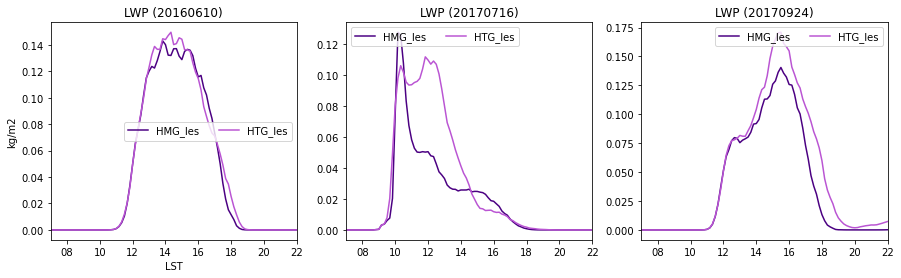

In [35]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = None

axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.lwp.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.lwp.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
# axs[0].plot(days_all_20160610.time.values,
#             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HMG').values),
#             color='red', label='HMG')
# # axs[0].plot(days_all_20160610.time.values,
# #             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HTG*01').values),
# #             color='dodgerblue', label='HTG*01')
# axs[0].plot(days_all_20160610.time.values,
#             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HTG*LESvals250').values),
#             color='limegreen', label='HTG*LESvals250')
axs[0].legend(ncol=2)
axs[0].set_title('LWP (20160610)')
axs[0].set_xlim([LES_allCases_20160610.time.values[0], LES_allCases_20160610.time.values[-1]])
axs[0].set_ylabel('kg/m2')
axs[0].set_xlabel('LST')



axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.lwp.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.lwp.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
# axs[1].plot(days_all_20170716.time.values,
#             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HMG').values),
#             color='red', label='HMG')
# # axs[1].plot(days_all_20170716.time.values,
# #             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HTG*01').values),
# #             color='dodgerblue', label='HTG*01')
# axs[1].plot(days_all_20170716.time.values,
#             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HTG*LESvals250').values),
#             color='limegreen', label='HTG*LESvals250')
axs[1].legend(ncol=2,loc='upper left')
axs[1].set_title('LWP (20170716)')
axs[1].set_xlim([LES_allCases_20170716.time.values[0], LES_allCases_20170716.time.values[-1]])



axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.lwp.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.lwp.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
# axs[2].plot(days_all_20170924.time.values,
#             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HMG').values),
#             color='red', label='HMG')
# # axs[2].plot(days_all_20170924.time.values,
# #             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HTG*01').values),
# #             color='dodgerblue', label='HTG*01')
# axs[2].plot(days_all_20170924.time.values,
#             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HTG*LESvals250').values),
#             color='limegreen', label='HTG*LESvals250')
axs[2].legend(ncol=2)
axs[2].set_title('LWP (20170924)')
axs[2].set_xlim([LES_allCases_20170924.time.values[0], LES_allCases_20170924.time.values[-1]])


# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].set_ylim([0, 2.6e-7])
# axs[1].set_ylim([0, 4.5e-6])
# axs[2].set_ylim([0, 1.5e-7])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


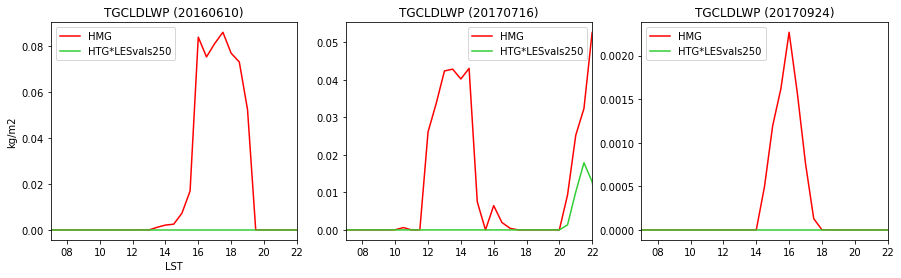

In [36]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = None

# axs[0].plot(LES_allCases_20160610.time.values, 
#             LES_allCases_20160610.lwp.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
# axs[0].plot(LES_allCases_20160610.time.values, 
#             LES_allCases_20160610.lwp.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HMG').values),
            color='red', label='HMG')
# axs[0].plot(days_all_20160610.time.values,
#             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HTG*01').values),
#             color='dodgerblue', label='HTG*01')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[0].legend()
axs[0].set_title('TGCLDLWP (20160610)')
axs[0].set_xlim([LES_allCases_20160610.time.values[0], LES_allCases_20160610.time.values[-1]])
axs[0].set_ylabel('kg/m2')
axs[0].set_xlabel('LST')



# axs[1].plot(LES_allCases_20170716.time.values, 
#             LES_allCases_20170716.lwp.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
# axs[1].plot(LES_allCases_20170716.time.values, 
#             LES_allCases_20170716.lwp.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HMG').values),
            color='red', label='HMG')
# axs[1].plot(days_all_20170716.time.values,
#             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HTG*01').values),
#             color='dodgerblue', label='HTG*01')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[1].legend()
axs[1].set_title('TGCLDLWP (20170716)')
axs[1].set_xlim([LES_allCases_20170716.time.values[0], LES_allCases_20170716.time.values[-1]])



# axs[2].plot(LES_allCases_20170924.time.values, 
#             LES_allCases_20170924.lwp.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
# axs[2].plot(LES_allCases_20170924.time.values, 
#             LES_allCases_20170924.lwp.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HMG').values),
            color='red', label='HMG')
# axs[2].plot(days_all_20170924.time.values,
#             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HTG*01').values),
#             color='dodgerblue', label='HTG*01')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[2].legend()
axs[2].set_title('TGCLDLWP (20170924)')
axs[2].set_xlim([LES_allCases_20170924.time.values[0], LES_allCases_20170924.time.values[-1]])


# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].set_ylim([0, 2.6e-7])
# axs[1].set_ylim([0, 4.5e-6])
# axs[2].set_ylim([0, 1.5e-7])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


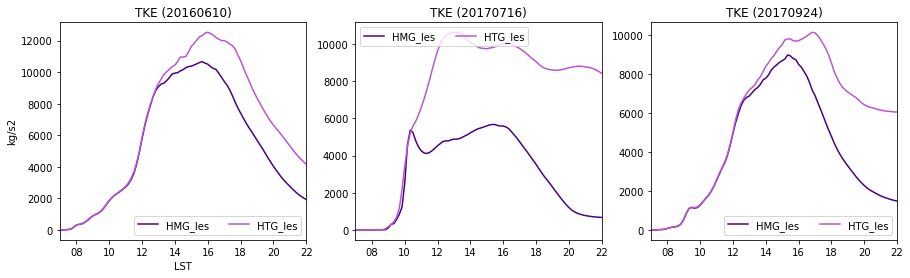

In [68]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = None

axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.tke.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[0].plot(LES_allCases_20160610.time.values, 
            LES_allCases_20160610.tke.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
# axs[0].plot(days_all_20160610.time.values,
#             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HMG').values),
#             color='red', label='HMG')
# # axs[0].plot(days_all_20160610.time.values,
# #             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HTG*01').values),
# #             color='dodgerblue', label='HTG*01')
# axs[0].plot(days_all_20160610.time.values,
#             np.squeeze(days_all_20160610.TGCLDLWP.sel(case='HTG*LESvals250').values),
#             color='limegreen', label='HTG*LESvals250')
axs[0].legend(ncol=2)
axs[0].set_title('TKE (20160610)')
axs[0].set_xlim([LES_allCases_20160610.time.values[0], LES_allCases_20160610.time.values[-1]])
axs[0].set_ylabel('kg/s2')
axs[0].set_xlabel('LST')



axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.tke.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[1].plot(LES_allCases_20170716.time.values, 
            LES_allCases_20170716.tke.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
# axs[1].plot(days_all_20170716.time.values,
#             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HMG').values),
#             color='red', label='HMG')
# # axs[1].plot(days_all_20170716.time.values,
# #             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HTG*01').values),
# #             color='dodgerblue', label='HTG*01')
# axs[1].plot(days_all_20170716.time.values,
#             np.squeeze(days_all_20170716.TGCLDLWP.sel(case='HTG*LESvals250').values),
#             color='limegreen', label='HTG*LESvals250')
axs[1].legend(ncol=2,loc='upper left')
axs[1].set_title('TKE (20170716)')
axs[1].set_xlim([LES_allCases_20170716.time.values[0], LES_allCases_20170716.time.values[-1]])



axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.tke.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
axs[2].plot(LES_allCases_20170924.time.values, 
            LES_allCases_20170924.tke.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
# axs[2].plot(days_all_20170924.time.values,
#             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HMG').values),
#             color='red', label='HMG')
# # axs[2].plot(days_all_20170924.time.values,
# #             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HTG*01').values),
# #             color='dodgerblue', label='HTG*01')
# axs[2].plot(days_all_20170924.time.values,
#             np.squeeze(days_all_20170924.TGCLDLWP.sel(case='HTG*LESvals250').values),
#             color='limegreen', label='HTG*LESvals250')
axs[2].legend(ncol=2)
axs[2].set_title('TKE (20170924)')
axs[2].set_xlim([LES_allCases_20170924.time.values[0], LES_allCases_20170924.time.values[-1]])


# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].set_ylim([0, 2.6e-7])
# axs[1].set_ylim([0, 4.5e-6])
# axs[2].set_ylim([0, 1.5e-7])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


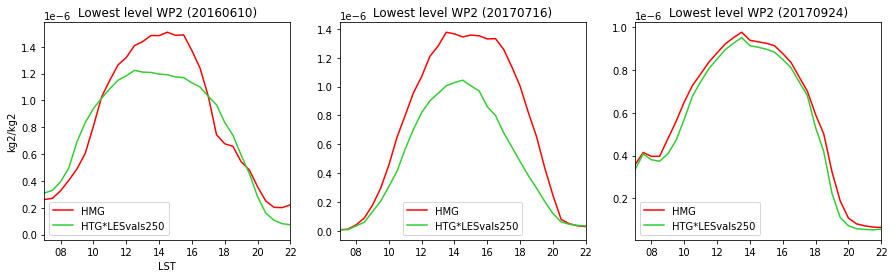

In [37]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = 0

# axs[0].plot(LES_allCases_20160610.time.values, 
#             LES_allCases_20160610.qv2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
# axs[0].plot(LES_allCases_20160610.time.values, 
#             LES_allCases_20160610.qv2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.WP2_CLUBB_interp.sel(case='HMG').isel(levInterp=-1).values)*(10.0**-6),
            color='red', 
            label='HMG')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.WP2_CLUBB_interp.sel(case='HTG*LESvals250').isel(levInterp=-1).values)*(10.0**-6),
            color='limegreen', 
            label='HTG*LESvals250')
axs[0].legend()
axs[0].set_title('Lowest level WP2 (20160610)')
axs[0].set_xlim([LES_allCases_20160610.time.values[0], LES_allCases_20160610.time.values[-1]])
axs[0].set_ylabel('kg2/kg2')
axs[0].set_xlabel('LST')



# axs[1].plot(LES_allCases_20170716.time.values, 
#             LES_allCases_20170716.qv2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
# axs[1].plot(LES_allCases_20170716.time.values, 
#             LES_allCases_20170716.qv2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.WP2_CLUBB_interp.sel(case='HMG').isel(levInterp=-1).values)*(10.0**-6),
            color='red', 
            label='HMG')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.WP2_CLUBB_interp.sel(case='HTG*LESvals250').isel(levInterp=-1).values)*(10.0**-6),
            color='limegreen', 
            label='HTG*LESvals250')
axs[1].legend()
axs[1].set_title('Lowest level WP2 (20170716)')
axs[1].set_xlim([LES_allCases_20170716.time.values[0], LES_allCases_20170716.time.values[-1]])



# axs[2].plot(LES_allCases_20170924.time.values, 
#             LES_allCases_20170924.qv2.sel(case='HMG').values[:,levPlot_LES],color='indigo',label='HMG_les')
# axs[2].plot(LES_allCases_20170924.time.values, 
#             LES_allCases_20170924.qv2.sel(case='HTG').values[:,levPlot_LES],color='mediumorchid',label='HTG_les')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.WP2_CLUBB.sel(case='HMG').isel(ilev=-1).values)*(10.0**-6),
            color='red', 
            label='HMG')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.WP2_CLUBB.sel(case='HTG*LESvals250').isel(ilev=-1).values)*(10.0**-6),
            color='limegreen', 
            label='HTG*LESvals250')
axs[2].legend()
axs[2].set_title('Lowest level WP2 (20170924)')
axs[2].set_xlim([LES_allCases_20170924.time.values[0], LES_allCases_20170924.time.values[-1]])


# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].set_ylim([0, 2.6e-7])
# axs[1].set_ylim([0, 4.5e-6])
# axs[2].set_ylim([0, 1.5e-7])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


In [20]:
LESshflx_20160610 = np.nanmean(np.nanmean(LES_allCasesDefault_20160610.AVS_SH.sel(case='HMG'),axis=1), axis=1)
LESshflx_20170716 = np.nanmean(np.nanmean(LES_allCasesDefault_20170716.AVS_SH.sel(case='HMG'),axis=1), axis=1)
LESshflx_20170924 = np.nanmean(np.nanmean(LES_allCasesDefault_20170924.AVS_SH.sel(case='HMG'),axis=1), axis=1)

LESlhflx_20160610 = np.nanmean(np.nanmean(LES_allCasesDefault_20160610.AVS_LH.sel(case='HMG'),axis=1), axis=1)
LESlhflx_20170716 = np.nanmean(np.nanmean(LES_allCasesDefault_20170716.AVS_LH.sel(case='HMG'),axis=1), axis=1)
LESlhflx_20170924 = np.nanmean(np.nanmean(LES_allCasesDefault_20170924.AVS_LH.sel(case='HMG'),axis=1), axis=1)


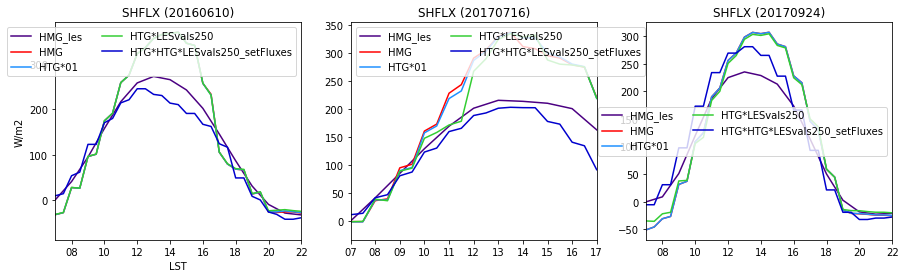

In [21]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = None

axs[0].plot(LES_allCasesDefault_20160610.Time.values, 
            LESshflx_20160610,color='indigo',label='HMG_les')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.SHFLX.sel(case='HMG').values),
            color='red', label='HMG')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.SHFLX.sel(case='HTG*01').values),
            color='dodgerblue', label='HTG*01')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.SHFLX.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.SHFLX.sel(case='HTG*LESvals250_setFluxes').values),
            color='mediumblue', label='HTG*HTG*LESvals250_setFluxes')
axs[0].legend(ncol=2)
axs[0].set_title('SHFLX (20160610)')
axs[0].set_xlim([LES_allCasesDefault_20160610.Time.values[0], LES_allCasesDefault_20160610.Time.values[-1]])
axs[0].set_ylabel('W/m2')
axs[0].set_xlabel('LST')



axs[1].plot(LES_allCasesDefault_20170716.Time.values, 
            LESshflx_20170716,color='indigo',label='HMG_les')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.SHFLX.sel(case='HMG').values),
            color='red', label='HMG')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.SHFLX.sel(case='HTG*01').values),
            color='dodgerblue', label='HTG*01')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.SHFLX.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.SHFLX.sel(case='HTG*LESvals250_setFluxes').values),
            color='mediumblue', label='HTG*HTG*LESvals250_setFluxes')
axs[1].legend(ncol=2,loc='upper left')
axs[1].set_title('SHFLX (20170716)')
axs[1].set_xlim([LES_allCasesDefault_20170716.Time.values[0], LES_allCasesDefault_20170716.Time.values[-1]])



axs[2].plot(LES_allCasesDefault_20170924.Time.values, 
            LESshflx_20170924,color='indigo',label='HMG_les')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.SHFLX.sel(case='HMG').values),
            color='red', label='HMG')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.SHFLX.sel(case='HTG*01').values),
            color='dodgerblue', label='HTG*01')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.SHFLX.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.SHFLX.sel(case='HTG*LESvals250_setFluxes').values),
            color='mediumblue', label='HTG*HTG*LESvals250_setFluxes')
axs[2].legend(ncol=2)
axs[2].set_title('SHFLX (20170924)')
axs[2].set_xlim([LES_allCasesDefault_20170924.Time.values[0], LES_allCasesDefault_20170924.Time.values[-1]])

# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].set_ylim([0, 2.6e-7])
# axs[1].set_ylim([0, 4.5e-6])
# axs[2].set_ylim([0, 1.5e-7])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


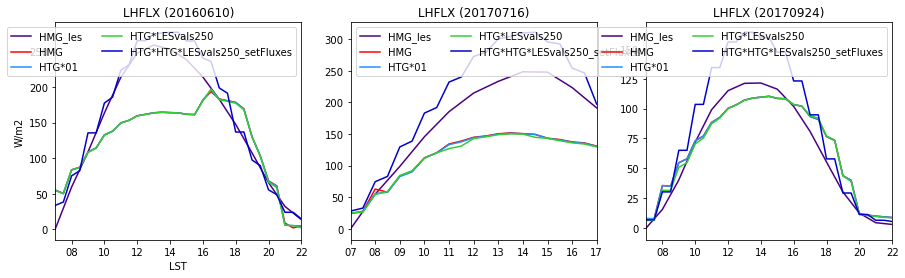

In [22]:
fig,axs=plt.subplots(1,3, figsize=(15,4))
axs    = axs.ravel()

levPlot_LES  = None

axs[0].plot(LES_allCasesDefault_20160610.Time.values, 
            LESlhflx_20160610,color='indigo',label='HMG_les')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.LHFLX.sel(case='HMG').values),
            color='red', label='HMG')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.LHFLX.sel(case='HTG*01').values),
            color='dodgerblue', label='HTG*01')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.LHFLX.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[0].plot(days_all_20160610.time.values,
            np.squeeze(days_all_20160610.LHFLX.sel(case='HTG*LESvals250_setFluxes').values),
            color='mediumblue', label='HTG*HTG*LESvals250_setFluxes')
axs[0].legend(ncol=2)
axs[0].set_title('LHFLX (20160610)')
axs[0].set_xlim([LES_allCasesDefault_20160610.Time.values[0], LES_allCasesDefault_20160610.Time.values[-1]])
axs[0].set_ylabel('W/m2')
axs[0].set_xlabel('LST')



axs[1].plot(LES_allCasesDefault_20170716.Time.values, 
            LESlhflx_20170716,color='indigo',label='HMG_les')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.LHFLX.sel(case='HMG').values),
            color='red', label='HMG')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.LHFLX.sel(case='HTG*01').values),
            color='dodgerblue', label='HTG*01')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.LHFLX.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[1].plot(days_all_20170716.time.values,
            np.squeeze(days_all_20170716.LHFLX.sel(case='HTG*LESvals250_setFluxes').values),
            color='mediumblue', label='HTG*HTG*LESvals250_setFluxes')
axs[1].legend(ncol=2,loc='upper left')
axs[1].set_title('LHFLX (20170716)')
axs[1].set_xlim([LES_allCasesDefault_20170716.Time.values[0], LES_allCasesDefault_20170716.Time.values[-1]])



axs[2].plot(LES_allCasesDefault_20170924.Time.values, 
            LESlhflx_20170924,color='indigo',label='HMG_les')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.LHFLX.sel(case='HMG').values),
            color='red', label='HMG')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.LHFLX.sel(case='HTG*01').values),
            color='dodgerblue', label='HTG*01')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.LHFLX.sel(case='HTG*LESvals250').values),
            color='limegreen', label='HTG*LESvals250')
axs[2].plot(days_all_20170924.time.values,
            np.squeeze(days_all_20170924.LHFLX.sel(case='HTG*LESvals250_setFluxes').values),
            color='mediumblue', label='HTG*HTG*LESvals250_setFluxes')
axs[2].legend(ncol=2)
axs[2].set_title('LHFLX (20170924)')
axs[2].set_xlim([LES_allCasesDefault_20170924.Time.values[0], LES_allCasesDefault_20170924.Time.values[-1]])

# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[0].set_ylim([0, 2.6e-7])
# axs[1].set_ylim([0, 4.5e-6])
# axs[2].set_ylim([0, 1.5e-7])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))


### Look at mean profiles

In [20]:
def air_density(p, t, q):
    '''Calculate the air density using the ideal gas law
    with the specific humidity of gas

    Parameters
    ----------
    p : float
        pressure [Pascals]
    t : float
        dry bulb temperature [Kelvin]
    q : float
        specific humidity [kg/kg]

    Return
    ------
    float
        air density [kg/m^3]
    '''
    
    ## Set some constants 
    Rd = 287.04
    ep = 0.622

    return p / (Rd * t * ((1. + (q/ep)) / (1. + q)))

In [21]:
## Look at mean profiles over a range of hours

hourStart = 9
hourEnd   = 12

## 2016/6/10
iHr_LES_20160610    = np.where((LES_allCases_20160610['time.hour']>=hourStart) & 
                               (LES_allCases_20160610['time.hour']<=hourEnd))[0]
LES_meanHr_20160610 = LES_allCases_20160610.isel(time=iHr_LES_20160610).mean(dim='time')

iHr_LESdef_20160610        = np.where((LES_allCasesDefault_20160610['Time.hour']>=hourStart) & 
                                      (LES_allCasesDefault_20160610['Time.hour']<=hourEnd))[0]
LESdefault_meanHr_20160610 = LES_allCasesDefault_20160610.isel(Time=iHr_LESdef_20160610).mean(dim='Time')

iHr_SCAM_20160610    = np.where((days_all_20160610['time.hour']>=hourStart) & 
                                (days_all_20160610['time.hour']<=hourEnd) )[0]
SCAM_meanHr_20160610 = days_all_20160610.isel(time=iHr_SCAM_20160610).mean(dim='time')


## 2017/7/16
iHr_LES_20170716    = np.where((LES_allCases_20170716['time.hour']>=hourStart) & 
                               (LES_allCases_20170716['time.hour']<=hourEnd))[0]
LES_meanHr_20170716 = LES_allCases_20170716.isel(time=iHr_LES_20170716).mean(dim='time')

iHr_LESdef_20170716        = np.where((LES_allCasesDefault_20170716['Time.hour']>=hourStart) & 
                                      (LES_allCasesDefault_20170716['Time.hour']<=hourEnd))[0]
LESdefault_meanHr_20170716 = LES_allCasesDefault_20170716.isel(Time=iHr_LESdef_20170716).mean(dim='Time')

iHr_SCAM_20170716    = np.where((days_all_20170716['time.hour']>=hourStart) & 
                                (days_all_20170716['time.hour']<=hourEnd) )[0]
SCAM_meanHr_20170716 = days_all_20170716.isel(time=iHr_SCAM_20170716).mean(dim='time')



## 2017/9/24
iHr_LES_20170924    = np.where((LES_allCases_20170924['time.hour']>=hourStart) & 
                               (LES_allCases_20170924['time.hour']<=hourEnd))[0]
LES_meanHr_20170924 = LES_allCases_20170924.isel(time=iHr_LES_20170924).mean(dim='time')

iHr_LESdef_20170924        = np.where((LES_allCasesDefault_20170924['Time.hour']>=hourStart) & 
                                      (LES_allCasesDefault_20170924['Time.hour']<=hourEnd))[0]
LESdefault_meanHr_20170924 = LES_allCasesDefault_20170924.isel(Time=iHr_LESdef_20170924).mean(dim='Time')

iHr_SCAM_20170924    = np.where((days_all_20170924['time.hour']>=hourStart) & 
                                (days_all_20170924['time.hour']<=hourEnd) )[0]
SCAM_meanHr_20170924 = days_all_20170924.isel(time=iHr_SCAM_20170924).mean(dim='time')

print('Means computed over local hours %i - %i' % (hourStart, hourEnd))

Means computed over local hours 9 - 12


In [22]:
## For WPTHL and WPRTP, need to convert units in SCAM, so define constants and get air density 

cpair       = 1004.64  #heat capacity dry air at const pres (j/kg/k)
lv          = 2.5*10**6 #J/Kg

rhoairHMG_20160610   = air_density(SCAM_meanHr_20160610.levInterp.values*100.0, 
                       np.squeeze(SCAM_meanHr_20160610.T_interp.sel(case='HMG').values), 
                       np.squeeze(SCAM_meanHr_20160610.Q_interp.sel(case='HMG').values) )   #air density of air 
rhoairHTG_20160610   = air_density(SCAM_meanHr_20160610.levInterp.values*100.0, 
                       np.squeeze(SCAM_meanHr_20160610.T_interp.sel(case='HTG*LESvals250').values), 
                       np.squeeze(SCAM_meanHr_20160610.Q_interp.sel(case='HTG*LESvals250').values) )   #air density of air 

rhoairHMG_20170716   = air_density(SCAM_meanHr_20170716.levInterp.values*100.0, 
                       np.squeeze(SCAM_meanHr_20170716.T_interp.sel(case='HMG').values), 
                       np.squeeze(SCAM_meanHr_20170716.Q_interp.sel(case='HMG').values) )   #air density of air 
rhoairHTG_20170716   = air_density(SCAM_meanHr_20170716.levInterp.values*100.0, 
                       np.squeeze(SCAM_meanHr_20170716.T_interp.sel(case='HTG*LESvals250').values), 
                       np.squeeze(SCAM_meanHr_20170716.Q_interp.sel(case='HTG*LESvals250').values) )   #air density of air 

rhoairHMG_20170924   = air_density(SCAM_meanHr_20170924.levInterp.values*100.0, 
                       np.squeeze(SCAM_meanHr_20170924.T_interp.sel(case='HMG').values), 
                       np.squeeze(SCAM_meanHr_20170924.Q_interp.sel(case='HMG').values) )   #air density of air 
rhoairHTG_20170924   = air_density(SCAM_meanHr_20170924.levInterp.values*100.0, 
                       np.squeeze(SCAM_meanHr_20170924.T_interp.sel(case='HTG*LESvals250').values), 
                       np.squeeze(SCAM_meanHr_20170924.Q_interp.sel(case='HTG*LESvals250').values) )   #air density of air 


(0.0, 5000.0)

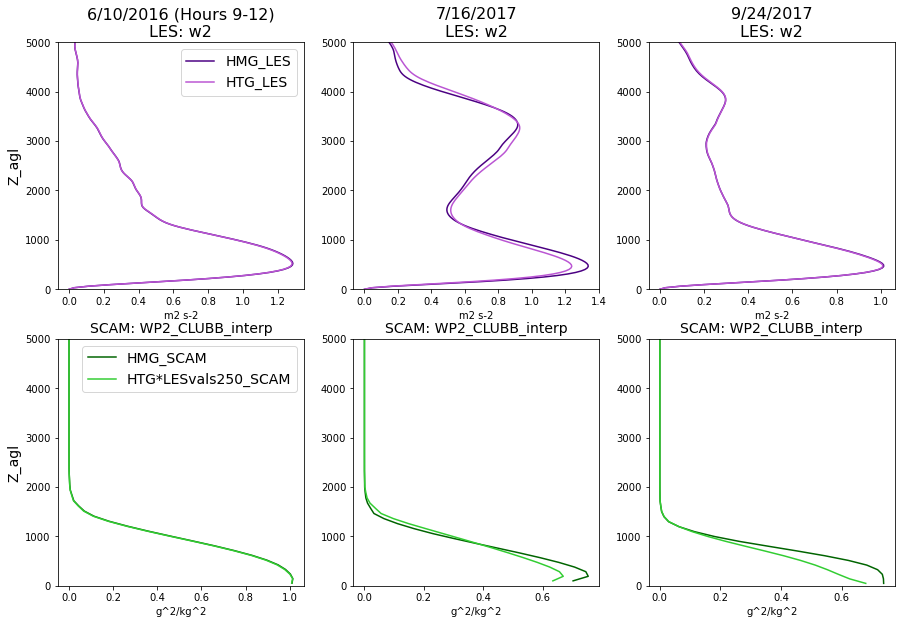

In [77]:
# SCAMvar = 'THLP2_CLUBB_interp'
# LESvar  = 'thl2' 
# LESvert = 'z'

# SCAMvar = 'RTP2_CLUBB_interp'
# LESvar  = 'qv2' 
# LESvert = 'z'

SCAMvar = 'WP2_CLUBB_interp'
LESvar  = 'w2' 
LESvert = 'zw'

fig,axs = plt.subplots(2,3, figsize=(15,10))
axs     = axs.ravel()

## ---- 2016/6/10 ---- ## 
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HMG').values, LES_meanHr_20160610[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HTG').values, LES_meanHr_20160610[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 
axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)


## ---- 2017/7/16 ---- ## 
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HMG').values, LES_meanHr_20170716[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HTG').values, LES_meanHr_20170716[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 


## ---- 2017/9/24 ---- ## 
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HMG').values, LES_meanHr_20170924[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HTG').values, LES_meanHr_20170924[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 

## Set titles 
axs[0].set_title(str(days_all_20160610['time.month'].values[0]) + '/'+
                 str(days_all_20160610['time.day'].values[0]) + '/' +
                 str(days_all_20160610['time.year'].values[0]) + ' (Hours '+str(hourStart)+'-'+str(hourEnd)+')'+
                 '\nLES: '+
                 LESvar, fontsize=16)
axs[1].set_title(str(days_all_20170716['time.month'].values[0]) + '/'+
                 str(days_all_20170716['time.day'].values[0]) + '/' +
                 str(days_all_20170716['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)
axs[2].set_title(str(days_all_20170924['time.month'].values[0]) + '/'+
                 str(days_all_20170924['time.day'].values[0]) + '/' +
                 str(days_all_20170924['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)

axs[3].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[4].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[5].set_title('SCAM: '+SCAMvar, fontsize=14)

axs[0].set_ylabel('Z_agl', fontsize=14)
axs[3].set_ylabel('Z_agl', fontsize=14)

axs[0].set_xlabel(LES_allCases[LESvar].units) 
axs[1].set_xlabel(LES_allCases[LESvar].units) 
axs[2].set_xlabel(LES_allCases[LESvar].units) 
axs[3].set_xlabel(multDS_allCases['RTP2_CLUBB'].units) 
axs[4].set_xlabel(multDS_allCases['RTP2_CLUBB'].units) 
axs[5].set_xlabel(multDS_allCases['RTP2_CLUBB'].units) 

## Set limits 
axs[0].set_ylim([0, 5000])
axs[1].set_ylim([0, 5000])
axs[2].set_ylim([0, 5000])

axs[3].set_ylim([0, 5000])
axs[4].set_ylim([0, 5000])
axs[5].set_ylim([0, 5000])



(0.0, 5000.0)

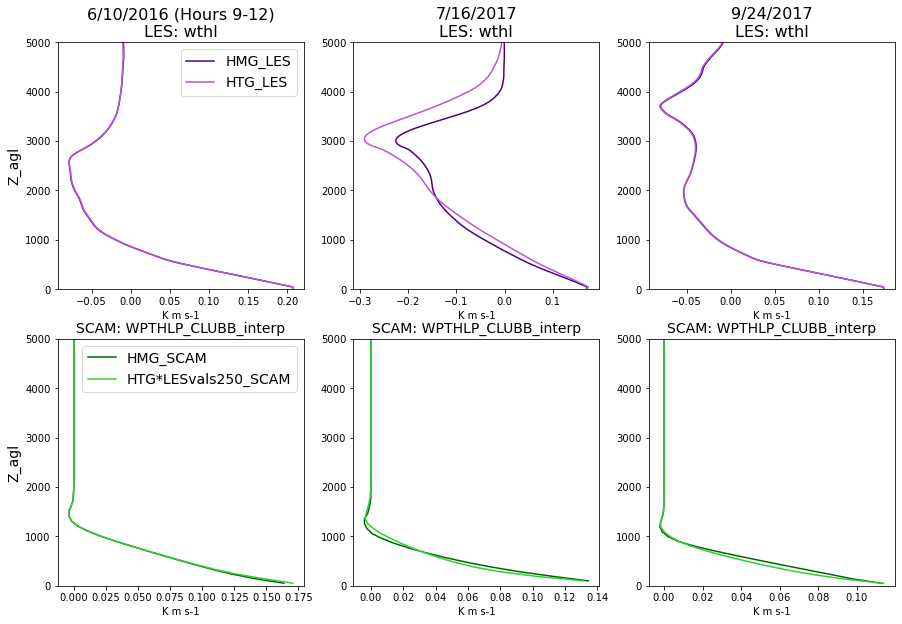

In [23]:
## For WPTHL, need to convert from W/m2 to K m/s again (in SCAM): 

SCAMvar = 'WPTHLP_CLUBB_interp'
LESvar  = 'wthl' 
LESvert = 'z'

fig,axs = plt.subplots(2,3, figsize=(15,10))
axs     = axs.ravel()

## ---- 2016/6/10 ---- ## 
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HMG').values, LES_meanHr_20160610[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HTG').values, LES_meanHr_20160610[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HMG').values)/cpair/rhoairHMG_20160610, 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HTG*LESvals250').values)/cpair/rhoairHTG_20160610, 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 
axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)

## ---- 2017/7/16 ---- ## 
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HMG').values, LES_meanHr_20170716[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HTG').values, LES_meanHr_20170716[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HMG').values)/cpair/rhoairHMG_20170716, 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HTG*LESvals250').values)/cpair/rhoairHTG_20170716, 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 


## ---- 2017/9/24 ---- ## 
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HMG').values, LES_meanHr_20170924[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HTG').values, LES_meanHr_20170924[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HMG').values)/cpair/rhoairHMG_20170924, 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HTG*LESvals250').values)/cpair/rhoairHTG_20170924, 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 

## Set titles 
axs[0].set_title(str(days_all_20160610['time.month'].values[0]) + '/'+
                 str(days_all_20160610['time.day'].values[0]) + '/' +
                 str(days_all_20160610['time.year'].values[0]) + ' (Hours '+str(hourStart)+'-'+str(hourEnd)+')'+
                 '\nLES: '+
                 LESvar, fontsize=16)
axs[1].set_title(str(days_all_20170716['time.month'].values[0]) + '/'+
                 str(days_all_20170716['time.day'].values[0]) + '/' +
                 str(days_all_20170716['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)
axs[2].set_title(str(days_all_20170924['time.month'].values[0]) + '/'+
                 str(days_all_20170924['time.day'].values[0]) + '/' +
                 str(days_all_20170924['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)

axs[3].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[4].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[5].set_title('SCAM: '+SCAMvar, fontsize=14)

axs[0].set_ylabel('Z_agl', fontsize=14)
axs[3].set_ylabel('Z_agl', fontsize=14)

axs[0].set_xlabel(LES_allCases[LESvar].units) 
axs[1].set_xlabel(LES_allCases[LESvar].units) 
axs[2].set_xlabel(LES_allCases[LESvar].units) 
# axs[3].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
# axs[4].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
# axs[5].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
axs[3].set_xlabel(LES_allCases[LESvar].units) 
axs[4].set_xlabel(LES_allCases[LESvar].units) 
axs[5].set_xlabel(LES_allCases[LESvar].units) 

## Set limits 
axs[0].set_ylim([0, 5000])
axs[1].set_ylim([0, 5000])
axs[2].set_ylim([0, 5000])

axs[3].set_ylim([0, 5000])
axs[4].set_ylim([0, 5000])
axs[5].set_ylim([0, 5000])



(0.0, 5000.0)

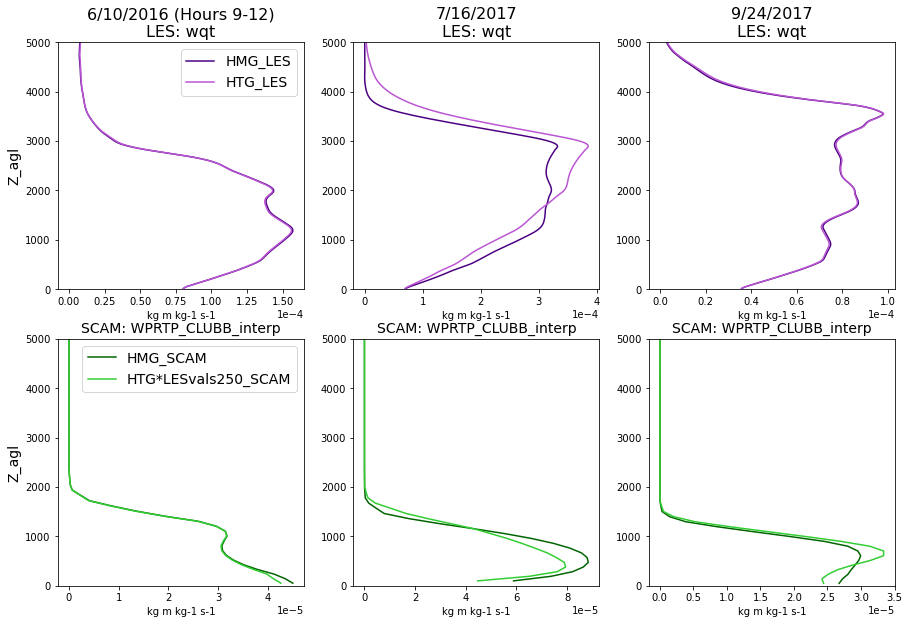

In [24]:
## For WPTHL, need to convert from W/m2 to K m/s again (in SCAM): 

SCAMvar = 'WPRTP_CLUBB_interp'
LESvar  = 'wqt' 
LESvert = 'z'

fig,axs = plt.subplots(2,3, figsize=(15,10))
axs     = axs.ravel()

## ---- 2016/6/10 ---- ## 
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HMG').values, LES_meanHr_20160610[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HTG').values, LES_meanHr_20160610[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HMG').values)/lv/rhoairHMG_20160610, 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HTG*LESvals250').values)/lv/rhoairHTG_20160610, 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 
axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)

## ---- 2017/7/16 ---- ## 
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HMG').values, LES_meanHr_20170716[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HTG').values, LES_meanHr_20170716[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HMG').values)/lv/rhoairHMG_20170716, 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HTG*LESvals250').values)/lv/rhoairHTG_20170716, 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 


## ---- 2017/9/24 ---- ## 
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HMG').values, LES_meanHr_20170924[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HTG').values, LES_meanHr_20170924[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HMG').values)/lv/rhoairHMG_20170924, 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HTG*LESvals250').values)/lv/rhoairHTG_20170924, 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 

## Set titles 
axs[0].set_title(str(days_all_20160610['time.month'].values[0]) + '/'+
                 str(days_all_20160610['time.day'].values[0]) + '/' +
                 str(days_all_20160610['time.year'].values[0]) + ' (Hours '+str(hourStart)+'-'+str(hourEnd)+')'+
                 '\nLES: '+
                 LESvar, fontsize=16)
axs[1].set_title(str(days_all_20170716['time.month'].values[0]) + '/'+
                 str(days_all_20170716['time.day'].values[0]) + '/' +
                 str(days_all_20170716['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)
axs[2].set_title(str(days_all_20170924['time.month'].values[0]) + '/'+
                 str(days_all_20170924['time.day'].values[0]) + '/' +
                 str(days_all_20170924['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)

axs[3].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[4].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[5].set_title('SCAM: '+SCAMvar, fontsize=14)

axs[0].set_ylabel('Z_agl', fontsize=14)
axs[3].set_ylabel('Z_agl', fontsize=14)

axs[0].set_xlabel(LES_allCases[LESvar].units) 
axs[1].set_xlabel(LES_allCases[LESvar].units) 
axs[2].set_xlabel(LES_allCases[LESvar].units) 
# axs[3].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
# axs[4].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
# axs[5].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
axs[3].set_xlabel(LES_allCases[LESvar].units) 
axs[4].set_xlabel(LES_allCases[LESvar].units) 
axs[5].set_xlabel(LES_allCases[LESvar].units) 

axs[0].ticklabel_format(style='sci', axis='x',scilimits=(0,0))
axs[1].ticklabel_format(style='sci', axis='x',scilimits=(0,0))
axs[2].ticklabel_format(style='sci', axis='x',scilimits=(0,0))

## Set limits 
axs[0].set_ylim([0, 5000])
axs[1].set_ylim([0, 5000])
axs[2].set_ylim([0, 5000])

axs[3].set_ylim([0, 5000])
axs[4].set_ylim([0, 5000])
axs[5].set_ylim([0, 5000])



(0.0, 5000.0)

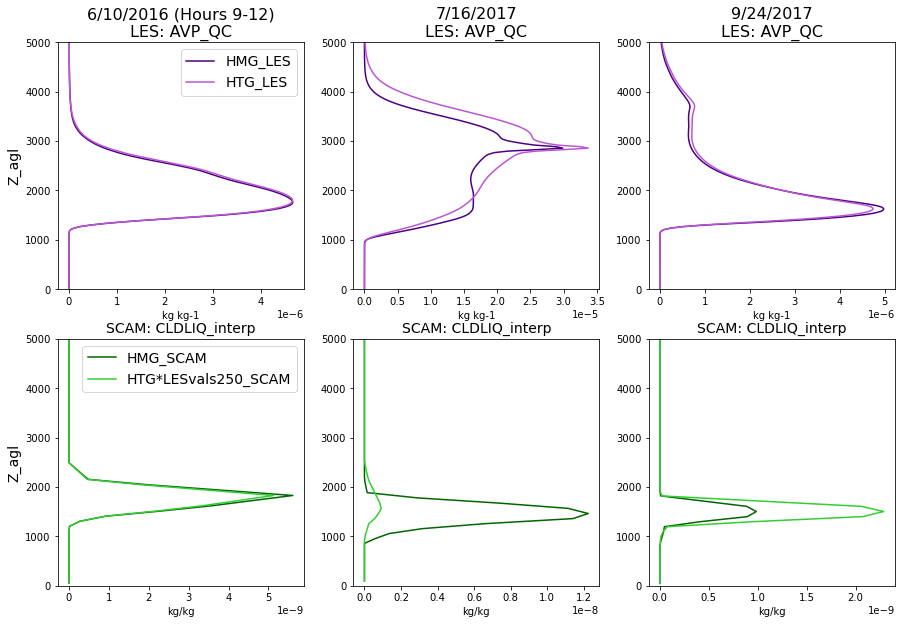

In [32]:
SCAMvar = 'CLDLIQ_interp'
LESvar  = 'AVP_QC' 
LESvert = 'z'


fig,axs = plt.subplots(2,3, figsize=(15,10))
axs     = axs.ravel()

## ---- 2016/6/10 ---- ## 
axs[0].plot(LESdefault_meanHr_20160610[LESvar].sel(case='HMG').values, LES_meanHr_20160610[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[0].plot(LESdefault_meanHr_20160610[LESvar].sel(case='HTG').values, LES_meanHr_20160610[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 
axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)


## ---- 2017/7/16 ---- ## 
axs[1].plot(LESdefault_meanHr_20170716[LESvar].sel(case='HMG').values, LES_meanHr_20170716[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[1].plot(LESdefault_meanHr_20170716[LESvar].sel(case='HTG').values, LES_meanHr_20170716[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 


## ---- 2017/9/24 ---- ## 
axs[2].plot(LESdefault_meanHr_20170924[LESvar].sel(case='HMG').values, LES_meanHr_20170924[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[2].plot(LESdefault_meanHr_20170924[LESvar].sel(case='HTG').values, LES_meanHr_20170924[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 

## Set titles 
axs[0].set_title(str(days_all_20160610['time.month'].values[0]) + '/'+
                 str(days_all_20160610['time.day'].values[0]) + '/' +
                 str(days_all_20160610['time.year'].values[0]) + ' (Hours '+str(hourStart)+'-'+str(hourEnd)+')'+
                 '\nLES: '+
                 LESvar, fontsize=16)
axs[1].set_title(str(days_all_20170716['time.month'].values[0]) + '/'+
                 str(days_all_20170716['time.day'].values[0]) + '/' +
                 str(days_all_20170716['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)
axs[2].set_title(str(days_all_20170924['time.month'].values[0]) + '/'+
                 str(days_all_20170924['time.day'].values[0]) + '/' +
                 str(days_all_20170924['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)

axs[3].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[4].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[5].set_title('SCAM: '+SCAMvar, fontsize=14)

axs[0].set_ylabel('Z_agl', fontsize=14)
axs[3].set_ylabel('Z_agl', fontsize=14)

axs[0].set_xlabel(LES_allCasesDefault [LESvar].units) 
axs[1].set_xlabel(LES_allCasesDefault[LESvar].units) 
axs[2].set_xlabel(LES_allCasesDefault[LESvar].units) 
axs[3].set_xlabel(multDS_allCases['CLDLIQ'].units) 
axs[4].set_xlabel(multDS_allCases['CLDLIQ'].units) 
axs[5].set_xlabel(multDS_allCases['CLDLIQ'].units) 

## Set limits 
axs[0].set_ylim([0, 5000])
axs[1].set_ylim([0, 5000])
axs[2].set_ylim([0, 5000])

axs[3].set_ylim([0, 5000])
axs[4].set_ylim([0, 5000])
axs[5].set_ylim([0, 5000])



(0.0, 5000.0)

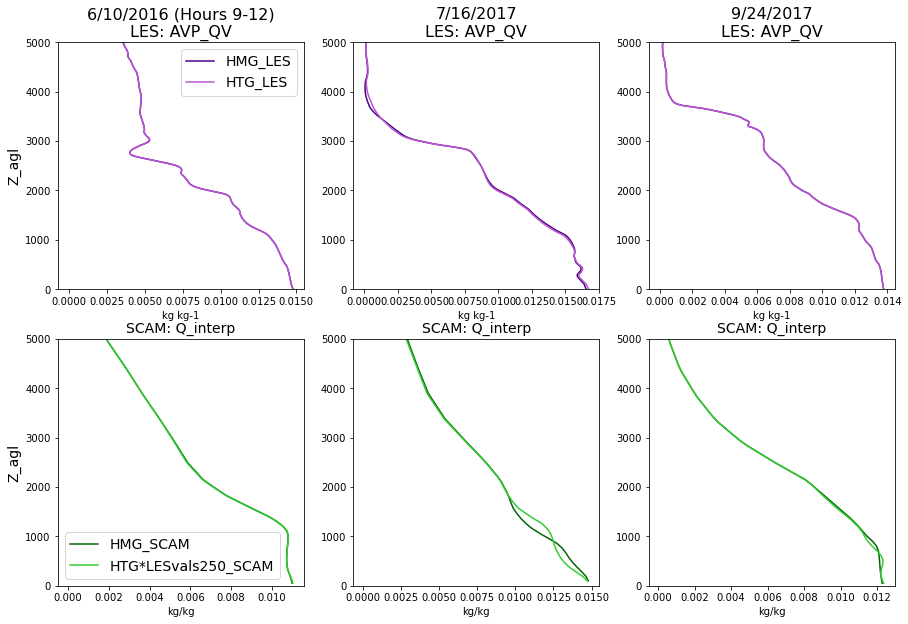

In [33]:
SCAMvar = 'Q_interp'
LESvar  = 'AVP_QV' 
LESvert = 'z'


fig,axs = plt.subplots(2,3, figsize=(15,10))
axs     = axs.ravel()

## ---- 2016/6/10 ---- ## 
axs[0].plot(LESdefault_meanHr_20160610[LESvar].sel(case='HMG').values, LES_meanHr_20160610[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[0].plot(LESdefault_meanHr_20160610[LESvar].sel(case='HTG').values, LES_meanHr_20160610[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 
axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)


## ---- 2017/7/16 ---- ## 
axs[1].plot(LESdefault_meanHr_20170716[LESvar].sel(case='HMG').values, LES_meanHr_20170716[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[1].plot(LESdefault_meanHr_20170716[LESvar].sel(case='HTG').values, LES_meanHr_20170716[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 


## ---- 2017/9/24 ---- ## 
axs[2].plot(LESdefault_meanHr_20170924[LESvar].sel(case='HMG').values, LES_meanHr_20170924[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[2].plot(LESdefault_meanHr_20170924[LESvar].sel(case='HTG').values, LES_meanHr_20170924[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HMG').values), 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HTG*LESvals250').values), 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 

## Set titles 
axs[0].set_title(str(days_all_20160610['time.month'].values[0]) + '/'+
                 str(days_all_20160610['time.day'].values[0]) + '/' +
                 str(days_all_20160610['time.year'].values[0]) + ' (Hours '+str(hourStart)+'-'+str(hourEnd)+')'+
                 '\nLES: '+
                 LESvar, fontsize=16)
axs[1].set_title(str(days_all_20170716['time.month'].values[0]) + '/'+
                 str(days_all_20170716['time.day'].values[0]) + '/' +
                 str(days_all_20170716['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)
axs[2].set_title(str(days_all_20170924['time.month'].values[0]) + '/'+
                 str(days_all_20170924['time.day'].values[0]) + '/' +
                 str(days_all_20170924['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)

axs[3].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[4].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[5].set_title('SCAM: '+SCAMvar, fontsize=14)

axs[0].set_ylabel('Z_agl', fontsize=14)
axs[3].set_ylabel('Z_agl', fontsize=14)

axs[0].set_xlabel(LES_allCasesDefault [LESvar].units) 
axs[1].set_xlabel(LES_allCasesDefault[LESvar].units) 
axs[2].set_xlabel(LES_allCasesDefault[LESvar].units) 
axs[3].set_xlabel(multDS_allCases['CLDLIQ'].units) 
axs[4].set_xlabel(multDS_allCases['CLDLIQ'].units) 
axs[5].set_xlabel(multDS_allCases['CLDLIQ'].units) 

## Set limits 
axs[0].set_ylim([0, 5000])
axs[1].set_ylim([0, 5000])
axs[2].set_ylim([0, 5000])

axs[3].set_ylim([0, 5000])
axs[4].set_ylim([0, 5000])
axs[5].set_ylim([0, 5000])



(0.0, 5000.0)

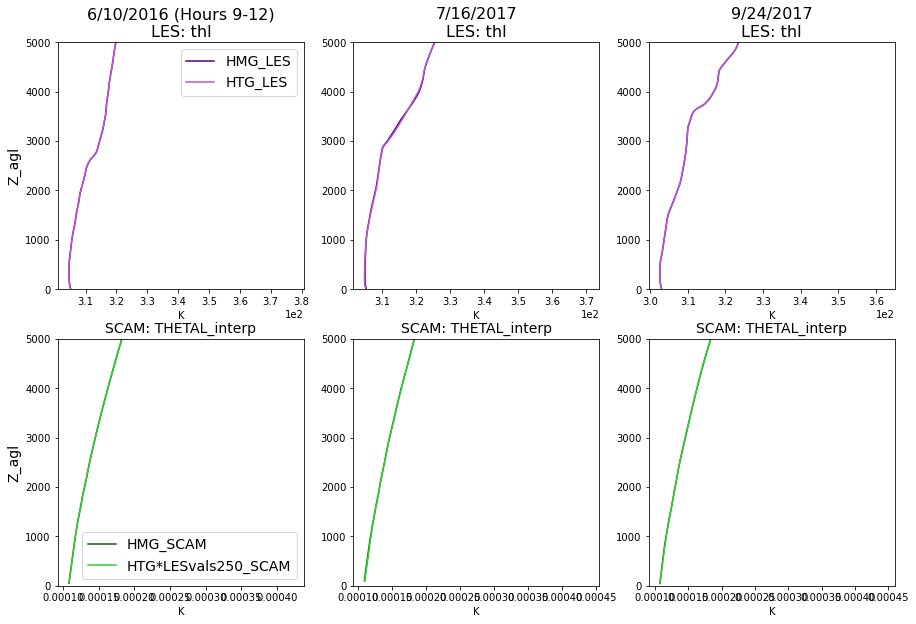

In [35]:
## For WPTHL, need to convert from W/m2 to K m/s again (in SCAM): 

SCAMvar = 'THETAL_interp'
LESvar  = 'thl' 
LESvert = 'z'

fig,axs = plt.subplots(2,3, figsize=(15,10))
axs     = axs.ravel()

## ---- 2016/6/10 ---- ## 
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HMG').values, LES_meanHr_20160610[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[0].plot(LES_meanHr_20160610[LESvar].sel(case='HTG').values, LES_meanHr_20160610[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HMG').values)/lv/rhoairHMG_20160610, 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[3].plot(np.squeeze(SCAM_meanHr_20160610[SCAMvar].sel(case='HTG*LESvals250').values)/lv/rhoairHTG_20160610, 
            np.squeeze(SCAM_meanHr_20160610.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 
axs[0].legend(fontsize=14)
axs[3].legend(fontsize=14)

## ---- 2017/7/16 ---- ## 
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HMG').values, LES_meanHr_20170716[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[1].plot(LES_meanHr_20170716[LESvar].sel(case='HTG').values, LES_meanHr_20170716[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HMG').values)/lv/rhoairHMG_20170716, 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[4].plot(np.squeeze(SCAM_meanHr_20170716[SCAMvar].sel(case='HTG*LESvals250').values)/lv/rhoairHTG_20170716, 
            np.squeeze(SCAM_meanHr_20170716.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 


## ---- 2017/9/24 ---- ## 
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HMG').values, LES_meanHr_20170924[LESvert].sel(case='HMG').values,'-',
            color='indigo',label='HMG_LES')
axs[2].plot(LES_meanHr_20170924[LESvar].sel(case='HTG').values, LES_meanHr_20170924[LESvert].sel(case='HTG').values,'-',
            color='mediumorchid',label='HTG_LES')
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HMG').values)/lv/rhoairHMG_20170924, 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='darkgreen', label='HMG_SCAM') 
axs[5].plot(np.squeeze(SCAM_meanHr_20170924[SCAMvar].sel(case='HTG*LESvals250').values)/lv/rhoairHTG_20170924, 
            np.squeeze(SCAM_meanHr_20170924.Z3_interp.values[0,:]), '-',
            color='limegreen', label='HTG*LESvals250_SCAM') 

## Set titles 
axs[0].set_title(str(days_all_20160610['time.month'].values[0]) + '/'+
                 str(days_all_20160610['time.day'].values[0]) + '/' +
                 str(days_all_20160610['time.year'].values[0]) + ' (Hours '+str(hourStart)+'-'+str(hourEnd)+')'+
                 '\nLES: '+
                 LESvar, fontsize=16)
axs[1].set_title(str(days_all_20170716['time.month'].values[0]) + '/'+
                 str(days_all_20170716['time.day'].values[0]) + '/' +
                 str(days_all_20170716['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)
axs[2].set_title(str(days_all_20170924['time.month'].values[0]) + '/'+
                 str(days_all_20170924['time.day'].values[0]) + '/' +
                 str(days_all_20170924['time.year'].values[0]) + '\nLES: '+
                 LESvar, fontsize=16)

axs[3].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[4].set_title('SCAM: '+SCAMvar, fontsize=14)
axs[5].set_title('SCAM: '+SCAMvar, fontsize=14)

axs[0].set_ylabel('Z_agl', fontsize=14)
axs[3].set_ylabel('Z_agl', fontsize=14)

axs[0].set_xlabel(LES_allCases[LESvar].units) 
axs[1].set_xlabel(LES_allCases[LESvar].units) 
axs[2].set_xlabel(LES_allCases[LESvar].units) 
# axs[3].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
# axs[4].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
# axs[5].set_xlabel(multDS_allCases['WP2_CLUBB'].units) 
axs[3].set_xlabel(LES_allCases[LESvar].units) 
axs[4].set_xlabel(LES_allCases[LESvar].units) 
axs[5].set_xlabel(LES_allCases[LESvar].units) 

axs[0].ticklabel_format(style='sci', axis='x',scilimits=(0,0))
axs[1].ticklabel_format(style='sci', axis='x',scilimits=(0,0))
axs[2].ticklabel_format(style='sci', axis='x',scilimits=(0,0))

## Set limits 
axs[0].set_ylim([0, 5000])
axs[1].set_ylim([0, 5000])
axs[2].set_ylim([0, 5000])

axs[3].set_ylim([0, 5000])
axs[4].set_ylim([0, 5000])
axs[5].set_ylim([0, 5000])



In [83]:
def meanProfile_plot(DS,varName,startHr,endHr,xmax,xmin,ymax,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["Time.hour"].values>=startHr) & 
                        (DS["Time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(Time=iTimeSel).mean(dim='Time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')[varName]
    HTGvar   = hourlyMean_DS.sel(case='HTG')[varName]
        
    fig,axs = plt.subplots(1,1, figsize=(5,6))
        
    axs.plot( np.squeeze(HMGvar.values), hourlyMean_DS[levName].sel(case='HMG').values, color='indigo', label=HMGvar.case.values )
    axs.plot( np.squeeze(HTGvar.values), hourlyMean_DS[levName].sel(case='HTG').values, color='mediumorchid', label=HTGvar.case.values )
    axs.legend(fontsize=12)
    axs.legend(fontsize=12)
    axs.set_ylim([0, ymax])
    # axs.invert_yaxis()
    axs.set_xlim([xmin,xmax])
    axs.set_title(varName+'\n'+
                  str(DS['Time.month'].values[0])+'/'+str(DS['Time.day'].values[0])+
                  ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)
    axs.set_ylabel('Z_agl', fontsize=14)
    
    # axs.ticklabel_format(style='sci', axis='x',scilimits=(0,0))

    
    return

In [82]:
LES_allCases.CSP_WQT.units

'kg/kg m/s'

Means computed over the inclusive period of 9 to 13.


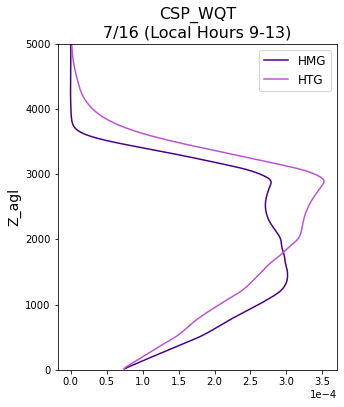

In [81]:
startHr = 9
endHr   = 13

meanProfile_plot(LES_allCases_20160610, 'CSP_WQT',
                 startHr,endHr,None,None,5000,'CSP_Z')

# meanProfile_plot(LES_allCases_20170924, 'CSP_WQT',
#                  startHr,endHr,None,None,5000,'CSP_Z')

# meanProfile_plot(LES_allCases_20170716, 'CSP_WQT',
#                  startHr,endHr,None,None,5000,'CSP_Z')

Means computed over the inclusive period of 9 to 13.


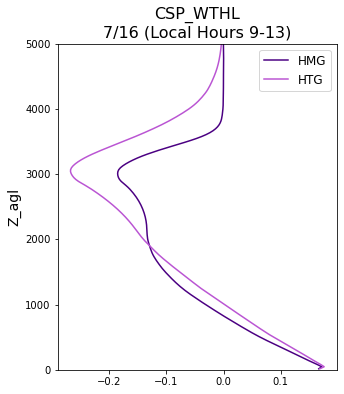

In [87]:
startHr = 9
endHr   = 13

# meanProfile_plot(LES_allCases_20160610, 'CSP_WTHL',
#                  startHr,endHr,None,None,5000,'CSP_Z')

# meanProfile_plot(LES_allCases_20170924, 'CSP_WTHL',
#                  startHr,endHr,None,None,5000,'CSP_Z')

meanProfile_plot(LES_allCases_20170716, 'CSP_WTHL',
                 startHr,endHr,None,None,5000,'CSP_Z')

Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.


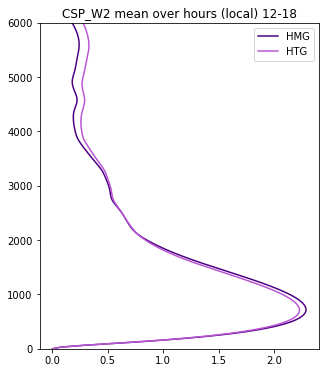

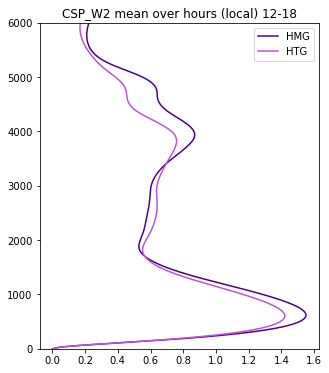

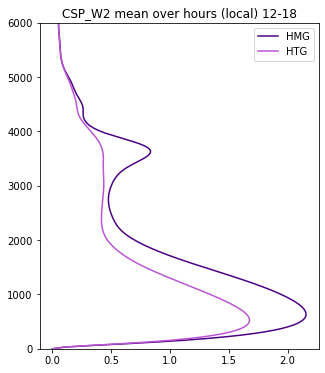

In [50]:
startHr = 12
endHr   = 18

meanProfile_plot(LES_allCases_20160610, 'CSP_W2',
                 startHr,endHr,None,None,6000,'CSP_Z8W')

meanProfile_plot(LES_allCases_20170924, 'CSP_W2',
                 startHr,endHr,None,None,6000,'CSP_Z8W')

meanProfile_plot(LES_allCases_20170716, 'CSP_W2',
                 startHr,endHr,None,None,6000,'CSP_Z8W')

**Make these plots for SCAM cases**

In [89]:
def meanProfile_plot(DS,varName,startHr,endHr,testCaseMult, xmax,xmin, ymin,ymax, levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')
    HTGmultVar = hourlyMean_DS.sel(case=testCaseMult)
        
    fig,axs = plt.subplots(1,1, figsize=(5,6))
    
    colorsList = ['orangered','dodgerblue','limegreen']
    
    axs.plot( np.squeeze(HMGvar[varName].values), np.squeeze(HMGvar[levName].values), color='orangered', label=HMGvar.case.values )
    axs.plot( np.squeeze(HTGvar[varName].values), np.squeeze(HTGvar[levName].values), color='dodgerblue', label=HTGvar.case.values )
    axs.plot( np.squeeze(HTGmultVar[varName].values), np.squeeze(HTGmultVar[levName].values), color='limegreen', label=HTGmultVar.case.values )
    axs.legend(fontsize=12)
    axs.set_ylim([ymin, ymax])
    # axs.invert_yaxis()
    axs.set_xlim([xmin,xmax])
    axs.set_title(varName+'\n'+
                  str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
                  ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)
    axs.set_ylabel('Z_agl', fontsize=14)
    
    return

Means computed over the inclusive period of 9 to 13.


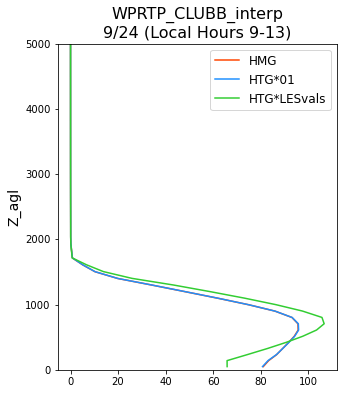

In [68]:
startHr = 9
endHr   = 13 

# meanProfile_plot(days_all_20160610,'WPRTP_CLUBB_interp',startHr,endHr,'HTG*LESvals',None,None,0,5000,'Z3_interp')
meanProfile_plot(days_all_20170924,'WPRTP_CLUBB_interp',startHr,endHr,'HTG*LESvals',None,None,0,5000,'Z3_interp')
# meanProfile_plot(days_all_20170716,'WPRTP_CLUBB_interp',startHr,endHr,'HTG*LESvals',None,None,0,5000,'Z3_interp')

Means computed over the inclusive period of 9 to 13.
Means computed over the inclusive period of 9 to 13.
Means computed over the inclusive period of 9 to 13.


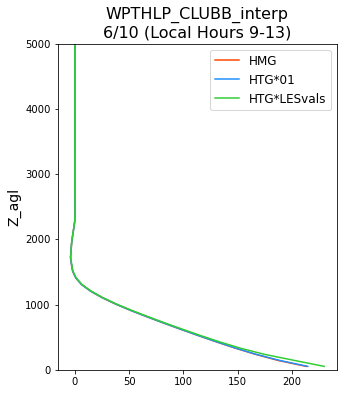

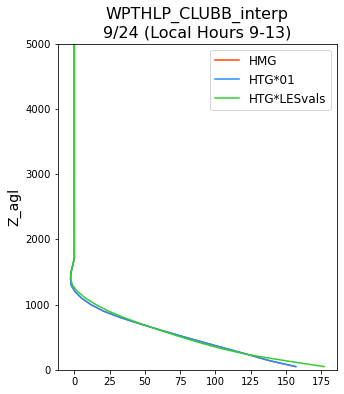

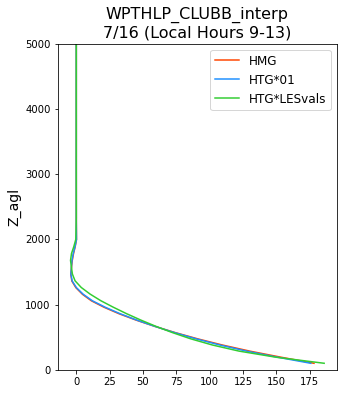

In [95]:
startHr = 9
endHr   = 13 

meanProfile_plot(days_all_20160610,'WPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',None,None,0,5000,'Z3_interp')
meanProfile_plot(days_all_20170924,'WPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',None,None,0,5000,'Z3_interp')
meanProfile_plot(days_all_20170716,'WPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',None,None,0,5000,'Z3_interp')

**Vertical velocity (don't have this in LES output)**

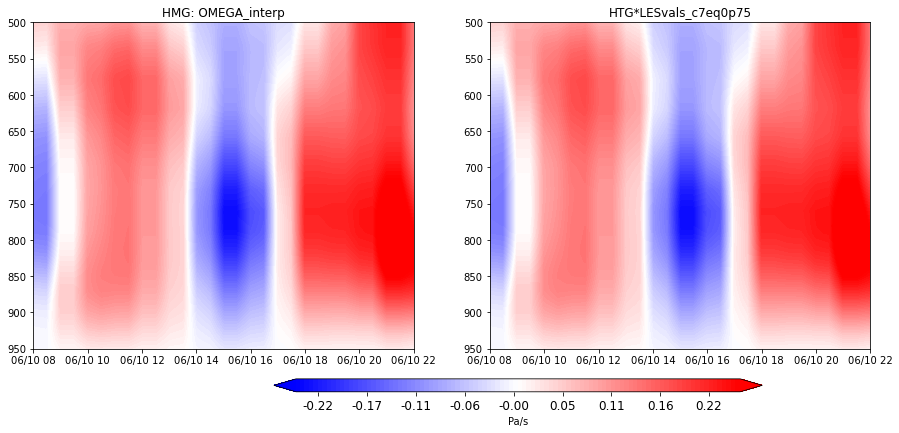

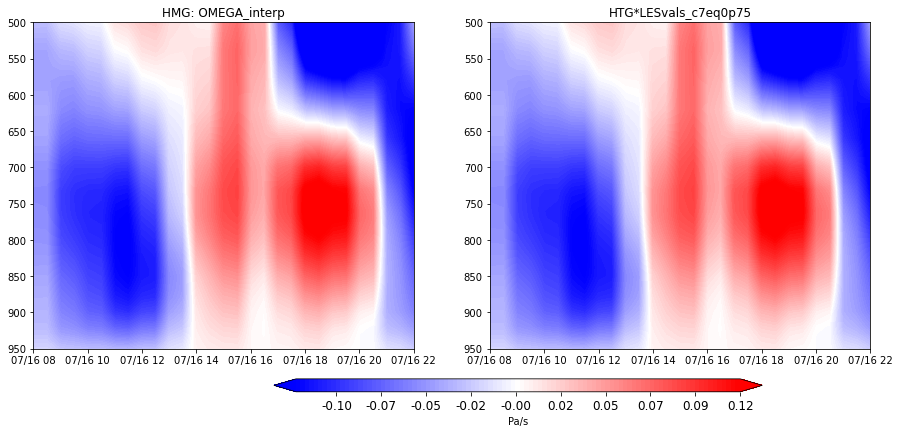

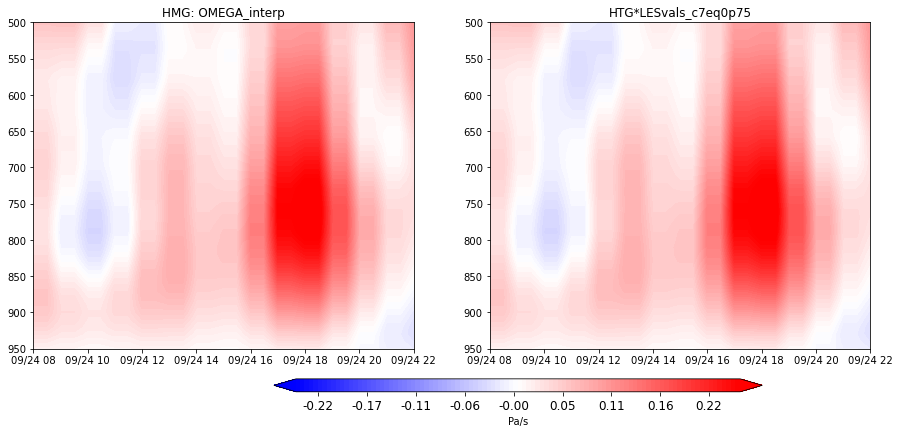

In [31]:
plotSCAM_timeHeight('OMEGA_interp', days_all_20160610, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=0.25, cbarMin=-0.25+(0.5/100),
                        unitsString=multDS_allCases.OMEGA.units)

plotSCAM_timeHeight('OMEGA_interp', days_all_20170716, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=0.12, cbarMin=-0.12+(0.24/100),
                        unitsString=multDS_allCases.OMEGA.units)

plotSCAM_timeHeight('OMEGA_interp', days_all_20170924, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=0.25, cbarMin=-0.25+(0.5/100),
                        unitsString=multDS_allCases.OMEGA.units)

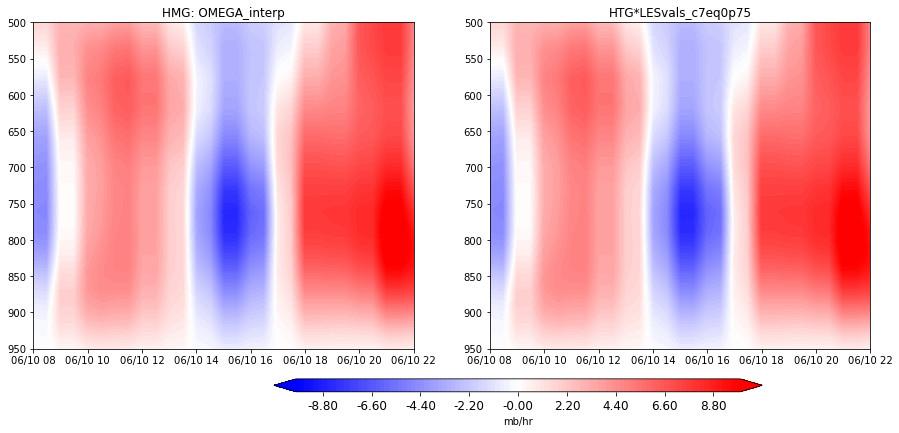

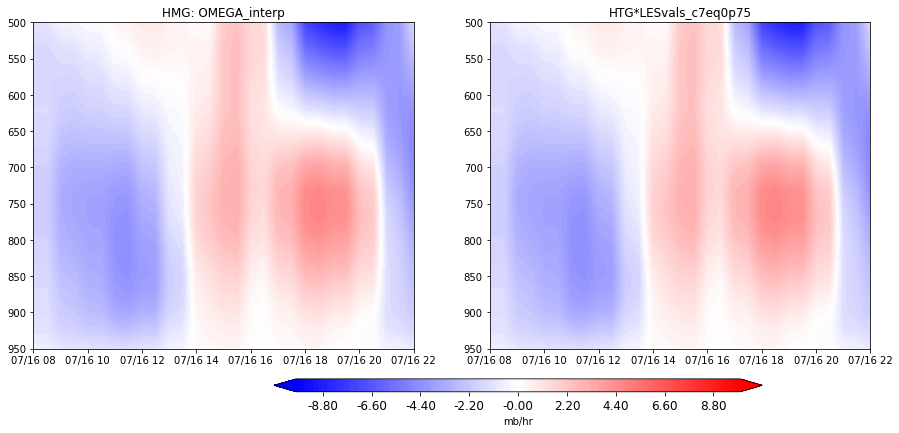

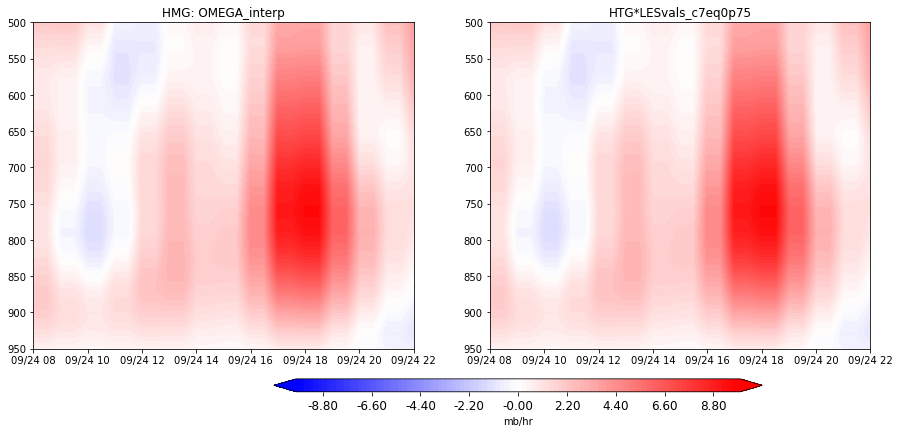

In [70]:
plotSCAM_timeHeight('OMEGA_interp', days_all_20160610, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=10, cbarMin=-10,
                        unitsString='mb/hr')

plotSCAM_timeHeight('OMEGA_interp', days_all_20170716, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=10, cbarMin=-10,
                        unitsString='mb/hr')

plotSCAM_timeHeight('OMEGA_interp', days_all_20170924, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=10, cbarMin=-10,
                        unitsString='mb/hr')

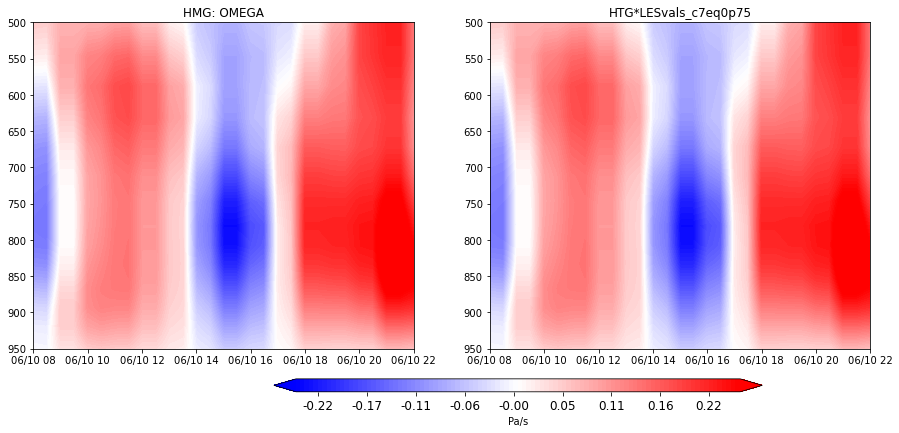

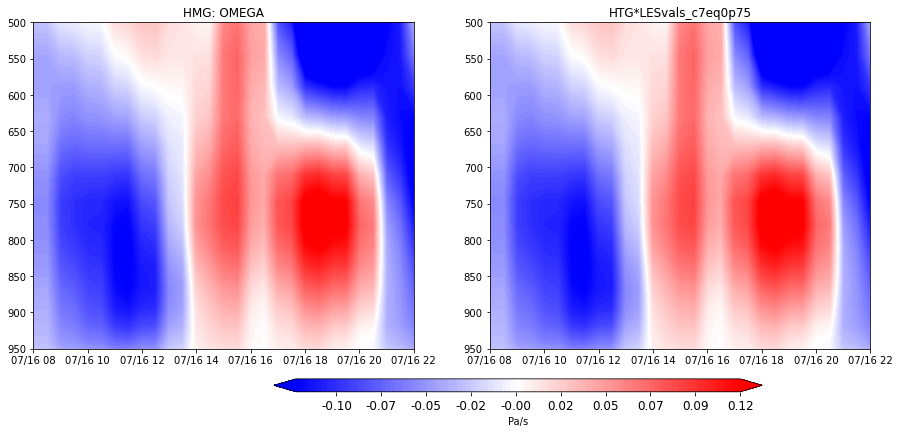

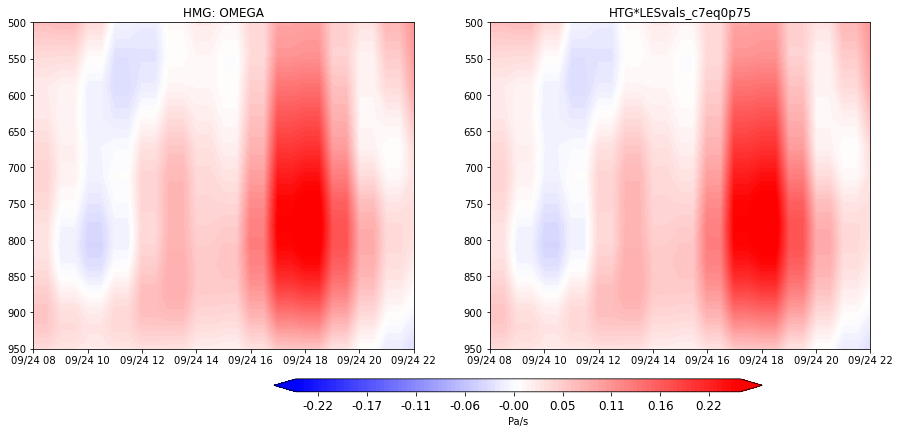

In [32]:
plotSCAM_timeHeight('OMEGA', days_all_20160610, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=0.25, cbarMin=-0.25+(0.5/100),
                        unitsString=multDS_allCases.OMEGA.units)

plotSCAM_timeHeight('OMEGA', days_all_20170716, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=0.12, cbarMin=-0.12+(0.24/100),
                        unitsString=multDS_allCases.OMEGA.units)

plotSCAM_timeHeight('OMEGA', days_all_20170924, case1 = 'HMG', case2 ='HTG*LESvals_c7eq0p75', 
                        cmapSel='bwr', ymax=500,ymin=950,
                        cbarFormat='%.2f', cbarMax=0.25, cbarMin=-0.25+(0.5/100),
                        unitsString=multDS_allCases.OMEGA.units)

## Look at the forcing file too (obs)

In [44]:
forcingFile  = '/glade/work/mdfowler/CLASP/clasp-htg.bdate.nc'
forcDS       = xr.open_dataset(forcingFile, decode_times=True)

## Convert to local time
localTimes  = forcDS['time'].values - np.timedelta64(5,'h')
forcDS      = forcDS.assign_coords({"time": localTimes})

## Pick out the days of interest 
iDay_20160610   = np.where( (forcDS['time.year']==2016) & (forcDS['time.month']==6) & (forcDS['time.day']==10) )[0]
forcDS_20160610 = forcDS.isel(time=iDay_20160610)

iDay_20170716   = np.where( (forcDS['time.year']==2017) & (forcDS['time.month']==7) & (forcDS['time.day']==16) )[0]
forcDS_20170716 = forcDS.isel(time=iDay_20170716)

iDay_20170924   = np.where( (forcDS['time.year']==2017) & (forcDS['time.month']==9) & (forcDS['time.day']==24) )[0]
forcDS_20170924 = forcDS.isel(time=iDay_20170924)

#### Compare to LES forcing file for 6/10/2016

In [62]:
forcingFileLES  = '/glade/work/mdfowler/CLASP/LESdata_fromJason/input_ls_forcing.nc'
forcLES         = xr.open_dataset(forcingFileLES, decode_times=True)
forcLES['Time'] = forcLES.Times.values


In [38]:
## Want to match with times in LES forcing file... 
timeUTC = forcDS_20160610.time.values+ np.timedelta64(5,'h')
forcDS_match = forcDS_20160610.isel(time=np.arange(7,len(forcDS_20160610.time.values),1))


In [83]:
## Convert units to be K/hr? 
forcLES_Tadv = forcLES.TH_ADV.values * 3600.0 
forcLES['forcLES_TadvUnits'] = (('Time', 'force_layers'), forcLES_Tadv)

## Convert units on qv_adv as well (currently kg/kg /s), want g/kg /hr
forcLES_Qadv = forcLES.QV_ADV.values * 3600.0 * 1000.0 
forcLES['forcLES_QadvUnits'] = (('Time', 'force_layers'), forcLES_Qadv)



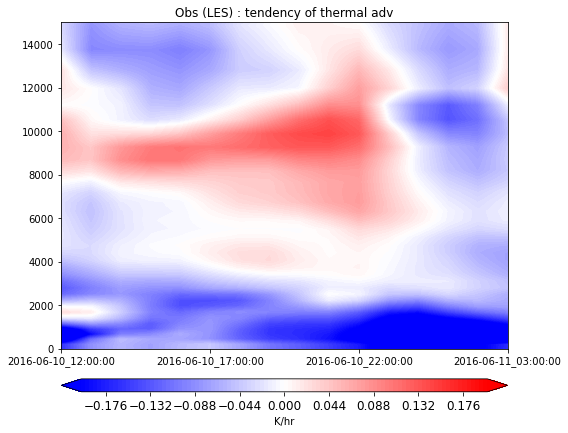

In [78]:
levC       = np.arange(-0.2, 0.2+(0.2*2)/100, (0.2*2)/100)

## Set up the plot
fig,axs = plt.subplots(1,1, figsize=(8,6))

cplt = axs.contourf(forcLES['Time'].values, 
                    forcLES['Z_LS'].mean(dim='Time').values,
                    np.squeeze(forcLES['forcLES_TadvUnits'].values).transpose(),
                    levC, cmap='bwr', extend='both')


axs.set_title('Obs (LES) : '+forcLES['TH_ADV'].description)


# # Use meaningful x-labels
# axs.xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs.xaxis.set_major_locator(plt.MaxNLocator(3))

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='K/hr')
cbar.ax.tick_params(labelsize=12) 


# axs.set_ylim([ymin,ymax])

# axs.set_xlim([pltDS.time.values[8], pltDS.time.values[-2]])



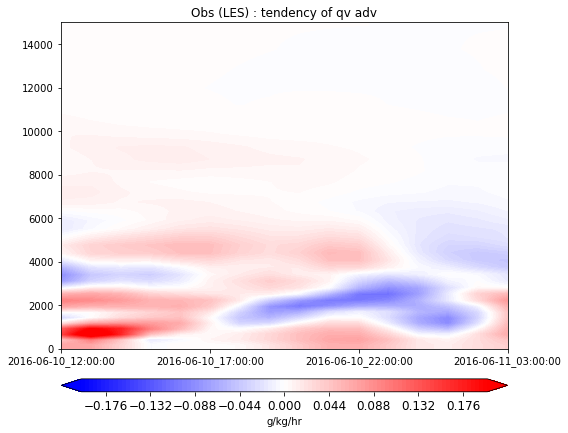

In [86]:
levC       = np.arange(-0.2, 0.2+(0.2*2)/100, (0.2*2)/100)

## Set up the plot
fig,axs = plt.subplots(1,1, figsize=(8,6))

cplt = axs.contourf(forcLES['Time'].values, 
                    forcLES['Z_LS'].mean(dim='Time').values,
                    np.squeeze(forcLES['forcLES_QadvUnits'].values).transpose(),
                    levC, cmap='bwr', extend='both')


axs.set_title('Obs (LES) : '+forcLES['QV_ADV'].description)


# # Use meaningful x-labels
# axs.xaxis.set_major_formatter(DateFormatter("%m/%d %H"))
axs.xaxis.set_major_locator(plt.MaxNLocator(3))

# Add colorbar
ax_position = axs.get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label='g/kg/hr')
cbar.ax.tick_params(labelsize=12) 


# axs.set_ylim([ymin,ymax])

# axs.set_xlim([pltDS.time.values[8], pltDS.time.values[-2]])



In [79]:
def plotObs_timeHeight(pltVar, pltDS, 
                       cmapSel='viridis', ymax=750, ymin=1000,
                       cbarFormat=None, cbarMax=None, cbarMin=None):
    
    ## Control intervals used in contouring
    if cbarMax==None:
        levSelMax  = np.nanpercentile([pltDS[pltVar].values], 99) 
    else: 
        levSelMax  = cbarMax 
        
    if cbarMin==None:
        levSelMin  = np.nanpercentile([pltDS[pltVar].values], 10) 
    else: 
        levSelMin = cbarMin 
    levC       = np.arange(levSelMin, levSelMax+(levSelMax-levSelMin)/100, (levSelMax-levSelMin)/100)
    
    ## Set up the plot
    fig,axs = plt.subplots(1,1, figsize=(8,6))

    cplt = axs.contourf(pltDS['time'].values, 
                        pltDS['lev'].values,
                        np.squeeze(pltDS[pltVar].values).transpose(),
                        levC, cmap=cmapSel, extend='both')


    axs.set_title('Obs (SCAM): '+pltDS[pltVar].long_name)


    # # Use meaningful x-labels
    axs.xaxis.set_major_formatter(DateFormatter("%m/%d %H"))

    # Add colorbar
    ax_position = axs.get_position()
    cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units, format=cbarFormat)
    cbar.ax.tick_params(labelsize=12) 

    # axs.invert_yaxis()
    
    axs.set_ylim([ymin,ymax])
 
    axs.set_xlim([pltDS.time.values[8], pltDS.time.values[-2]])
    
    return

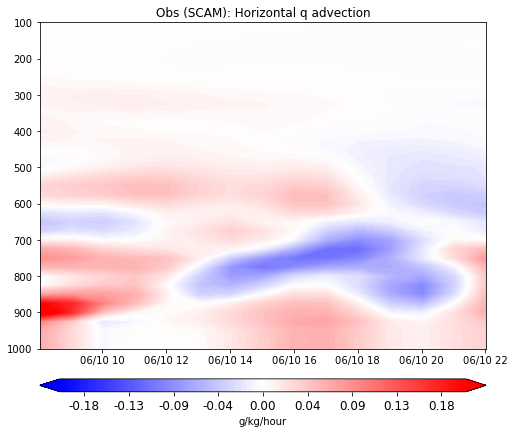

In [82]:
# plotObs_timeHeight('T_adv_h', forcDS_20160610, 
#                     cmapSel='bwr', ymax=2, ymin=1000,
#                     cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

plotObs_timeHeight('q_adv_h', forcDS_20160610, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)



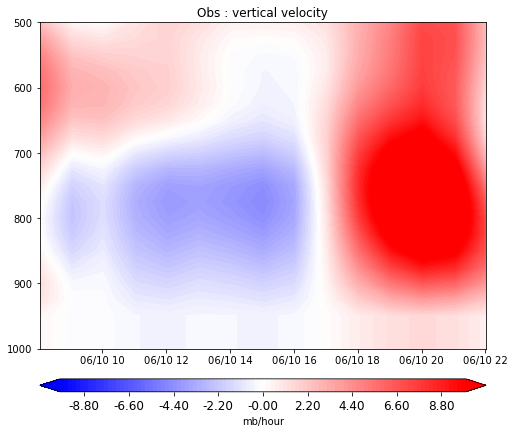

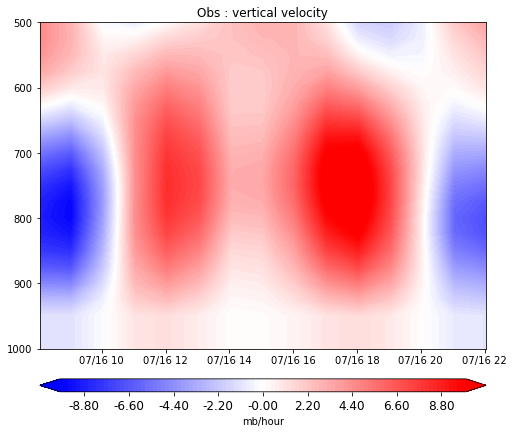

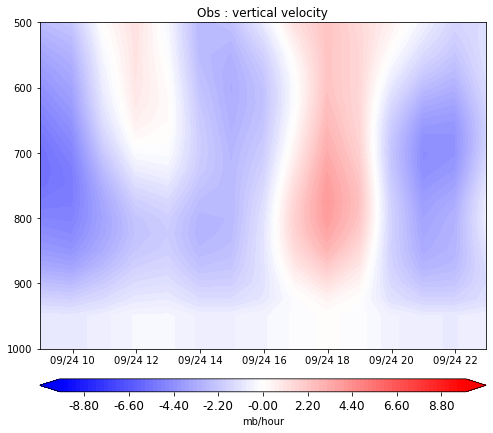

In [79]:
plotObs_timeHeight('omega', forcDS_20160610, 
                    cmapSel='bwr', ymax=500, ymin=1000,
                    cbarFormat='%.2f', cbarMax=10, cbarMin=-10)

plotObs_timeHeight('omega', forcDS_20170716, 
                    cmapSel='bwr', ymax=500, ymin=1000,
                    cbarFormat='%.2f', cbarMax=10, cbarMin=-10)

plotObs_timeHeight('omega', forcDS_20170924, 
                    cmapSel='bwr', ymax=500, ymin=1000,
                    cbarFormat='%.2f', cbarMax=10, cbarMin=-10)

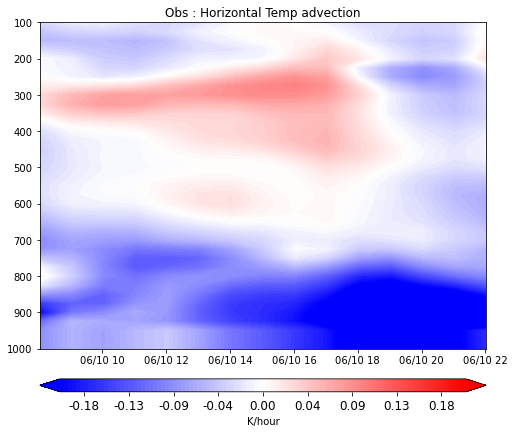

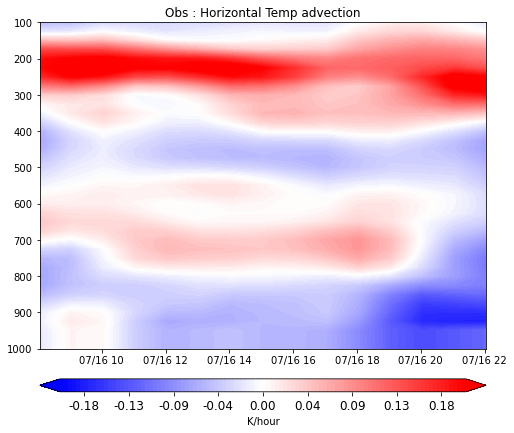

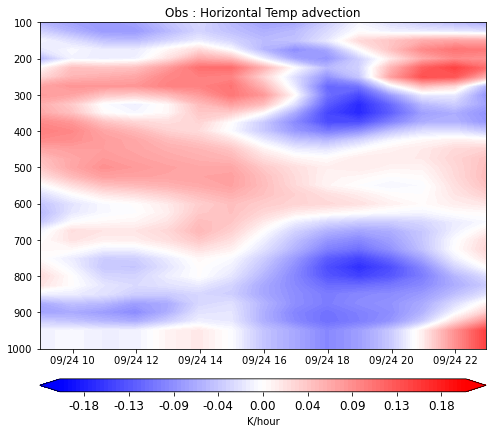

In [67]:
plotObs_timeHeight('T_adv_h', forcDS_20160610, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

plotObs_timeHeight('T_adv_h', forcDS_20170716, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

plotObs_timeHeight('T_adv_h', forcDS_20170924, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

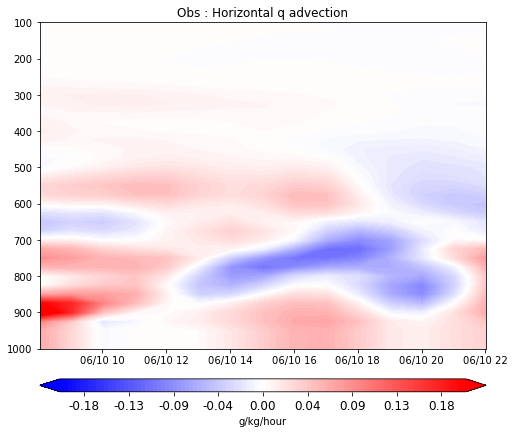

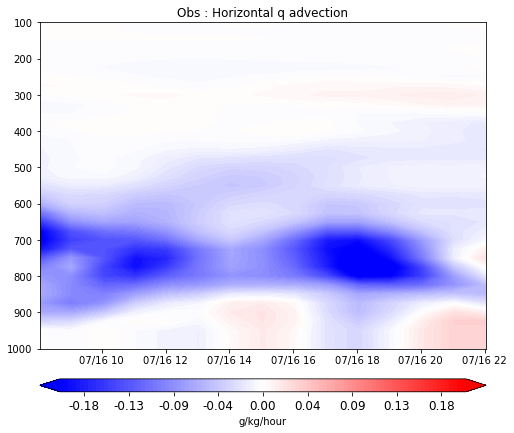

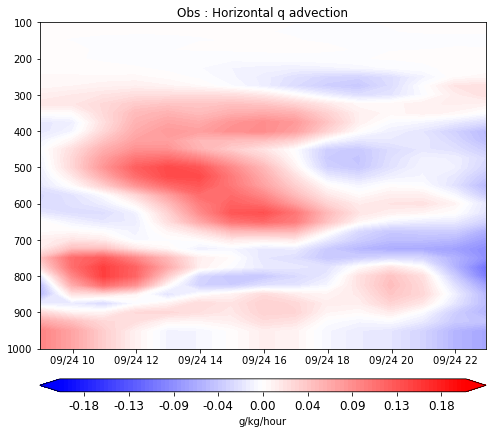

In [70]:
plotObs_timeHeight('q_adv_h', forcDS_20160610, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

plotObs_timeHeight('q_adv_h', forcDS_20170716, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

plotObs_timeHeight('q_adv_h', forcDS_20170924, 
                    cmapSel='bwr', ymax=100, ymin=1000,
                    cbarFormat='%.2f', cbarMax=0.2, cbarMin=-0.2)

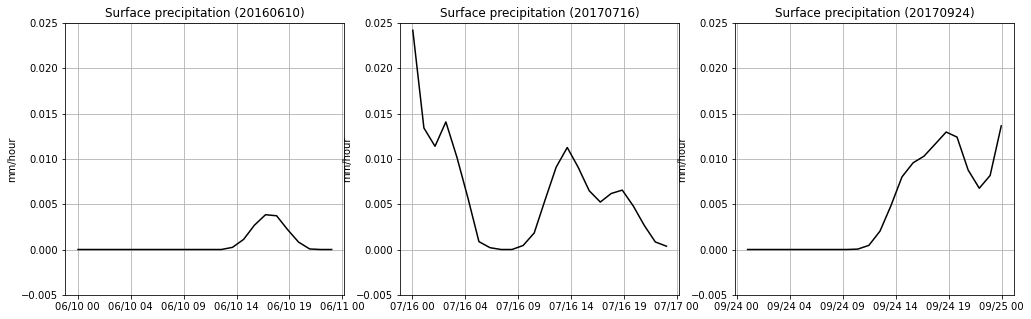

In [45]:
fig,axs = plt.subplots(1,3, figsize=(17,5))
axs = axs.ravel()

varPlot = 'prec_srf'
ymin = -0.005
ymax = 0.025

# varPlot = 'q_srf'
# ymin = 0.013
# ymax = 0.019

axs[0].plot(forcDS_20160610.time.values, 
            np.squeeze(forcDS_20160610[varPlot].values), 'k', label='obs')
axs[0].set_title(forcDS_20160610[varPlot].long_name+ ' (20160610)')
axs[0].set_ylabel(forcDS_20160610[varPlot].units)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))

axs[1].plot(forcDS_20170716.time.values, 
            np.squeeze(forcDS_20170716[varPlot].values), 'k', label='obs')
axs[1].set_title(forcDS_20170716[varPlot].long_name+ ' (20170716)')
axs[1].set_ylabel(forcDS_20170716[varPlot].units)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))

axs[2].plot(forcDS_20170924.time.values, 
            np.squeeze(forcDS_20170924[varPlot].values), 'k', label='obs')
axs[2].set_title(forcDS_20170924[varPlot].long_name+ ' (20170924)')
axs[2].set_ylabel(forcDS_20170924[varPlot].units)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[2].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))


axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])
axs[2].set_ylim([ymin, ymax])

axs[0].grid()
axs[1].grid()
axs[2].grid()

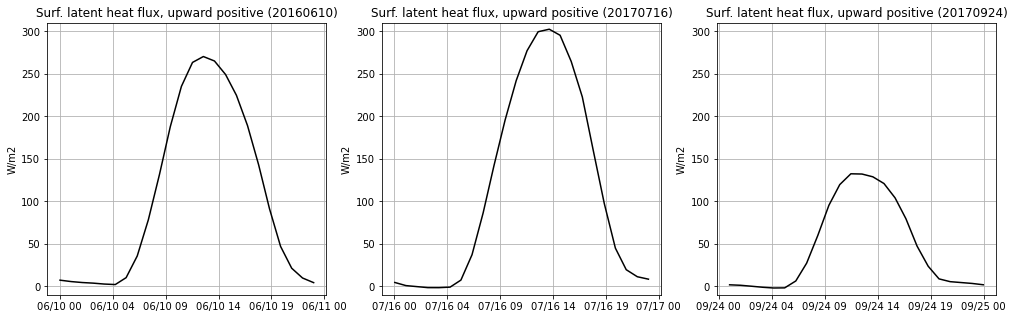

In [59]:
fig,axs = plt.subplots(1,3, figsize=(17,5))
axs = axs.ravel()

varPlot = 'LH'
ymin = -10
ymax = 310

# varPlot = 'q_srf'
# ymin = 0.013
# ymax = 0.019

axs[0].plot(forcDS_20160610.time.values, 
            np.squeeze(forcDS_20160610[varPlot].values), 'k', label='obs')
axs[0].set_title(forcDS_20160610[varPlot].long_name+ ' (20160610)')
axs[0].set_ylabel(forcDS_20160610[varPlot].units)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[0].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))

axs[1].plot(forcDS_20170716.time.values, 
            np.squeeze(forcDS_20170716[varPlot].values), 'k', label='obs')
axs[1].set_title(forcDS_20170716[varPlot].long_name+ ' (20170716)')
axs[1].set_ylabel(forcDS_20170716[varPlot].units)
axs[1].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[1].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))

axs[2].plot(forcDS_20170924.time.values, 
            np.squeeze(forcDS_20170924[varPlot].values), 'k', label='obs')
axs[2].set_title(forcDS_20170924[varPlot].long_name+ ' (20170924)')
axs[2].set_ylabel(forcDS_20170924[varPlot].units)
axs[2].xaxis.set_major_locator(plt.MaxNLocator(6))
axs[2].xaxis.set_major_formatter(DateFormatter("%m/%d %H"))


axs[0].set_ylim([ymin, ymax])
axs[1].set_ylim([ymin, ymax])
axs[2].set_ylim([ymin, ymax])

axs[0].grid()
axs[1].grid()
axs[2].grid()

In [76]:
LES_allCasesDefault_20160610

<xarray.Dataset>
Dimensions:   (Time: 16, bottom_top: 226, case: 2, south_north: 400, west_east: 400)
Coordinates:
  * Time      (Time) datetime64[ns] 2016-06-10T07:00:00 ... 2016-06-10T22:00:00
  * case      (case) object 'HMG' 'HTG'
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    AVT_T2    (case, Time) float32 0.0 296.9 299.0 301.6 ... 304.7 302.7 300.8
    AVT_Q2    (case, Time) float32 0.0 nan nan nan nan ... nan nan nan nan nan
    AVT_LWP   (case, Time) float32 0.0 0.0 0.0 1.064e-09 ... 1.758e-05 0.0 0.0
    AVS_T2    (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    AVS_Q2    (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    AVS_SH    (case, Time, south_north, west_east) float32 0.0 0.0 ... -26.57
    AVS_LH    (case, Time, south_north, west_east) float32 0.0 0.0 ... 15.66
    AVS_RAIN  (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    AVS_LWP   (case, Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    AVP_QV    (case, Time, bottom_top) float32 0.0 0.0 ... 3.184e-06 2.622e-06
    AVP_QC    (case, Time, bottom_top) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AVP_LWC   (case, Time, bottom_top) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AVV_TH    (case, Time, bottom_top, south_north, west_east) float32 0.0 .....
    AVV_THV   (case, Time, bottom_top, south_north, west_east) float32 0.0 .....
    AVV_QV    (case, Time, bottom_top, south_north, west_east) float32 0.0 .....
    AVV_QC    (case, Time, bottom_top, south_north, west_east) float32 0.0 .....
    AVV_LWC   (case, Time, bottom_top, south_north, west_east) float32 0.0 .....
Attributes:
    TITLE:                            OUTPUT FROM WRF V3.8.1 MODEL
    START_DATE:                      2016-06-10_12:00:00
    WEST-EAST_GRID_DIMENSION:        401
    SOUTH-NORTH_GRID_DIMENSION:      401
    BOTTOM-TOP_GRID_DIMENSION:       227
    DX:                              250.0
    DY:                              250.0
    GRIDTYPE:                        C
    DIFF_OPT:                        2
    KM_OPT:                          3
    DAMP_OPT:                        3
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      8
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               44
    SF_SURFACE_PHYSICS:              0
    BL_PBL_PHYSICS:                  0
    CU_PHYSICS:                      0
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            3
    SST_UPDATE:                      0
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 1
    USE_THETA_M:                     1
    WEST-EAST_PATCH_START_UNSTAG:    1
    WEST-EAST_PATCH_END_UNSTAG:      400
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_END_STAG:        401
    SOUTH-NORTH_PATCH_START_UNSTAG:  1
    SOUTH-NORTH_PATCH_END_UNSTAG:    400
    SOUTH-NORTH_PATCH_START_STAG:    1
    SOUTH-NORTH_PATCH_END_STAG:      401
    BOTTOM-TOP_PATCH_START_UNSTAG:   1
    BOTTOM-TOP_PATCH_END_UNSTAG:     226
    BOTTOM-TOP_PATCH_START_STAG:     1
    BOTTOM-TOP_PATCH_END_STAG:       227
    GRID_ID:                         1
    PARENT_ID:                       0
    I_PARENT_START:                  0
    J_PARENT_START:                  0
    PARENT_GRID_RATIO:               1
    DT:                              0.5
    CEN_LAT:                         0.0
    CEN_LON:                         0.0
    TRUELAT1:                        0.0
    TRUELAT2:                        0.0
    MOAD_CEN_LAT:                    0.0
    STAND_LON:                       0.0
    POLE_LAT:                        0.0
  

## Make animations?

In [21]:
## Grid spacing, dx and dy, is 250 m (or 0.25 km)
xvals = (LES_allCasesDefault_20160610.west_east.values)*0.250
yvals = (LES_allCasesDefault_20160610.south_north.values)*0.250

Text(0.5, 1.0, '\n9/24: Local Hour 13')

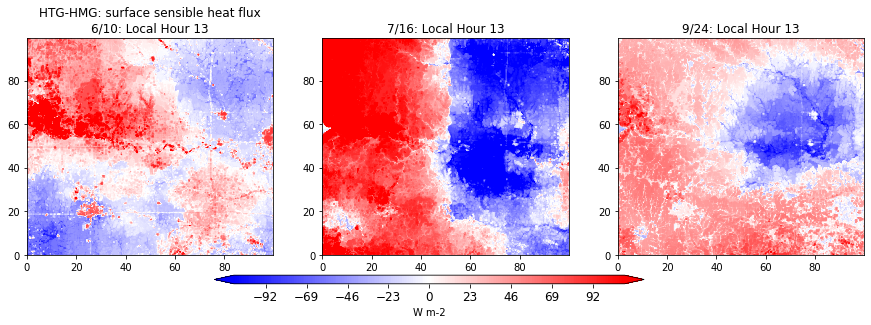

In [25]:
## Plot HTG-HMG difference per day at a selected hour 

pltVar = 'AVS_SH'
hrSel  = 13

htg_20160610 = LES_allCasesDefault_20160610.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
hmg_20160610 = LES_allCasesDefault_20160610.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
diff_20160610 = htg_20160610 - hmg_20160610


htg_20170716 = LES_allCasesDefault_20170716.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
hmg_20170716 = LES_allCasesDefault_20170716.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
diff_20170716 = htg_20170716 - hmg_20170716

htg_20170924 = LES_allCasesDefault_20170924.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
hmg_20170924 = LES_allCasesDefault_20170924.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
diff_20170924 = htg_20170924 - hmg_20170924


## Plot options 
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()
# levsDiff = np.arange(-0.1,0.11,0.01)   ## AVS_LWP
levsDiff = np.arange(-110,111,1)   ## AVS_SH
# levsDiff = np.arange(-2e-5, 2.05e-5, 0.05e-5)   ## AVS_RAIN


## Plot the difference 
axs[0].contourf(xvals, yvals, np.squeeze(diff_20160610[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

cplt = axs[1].contourf(xvals, yvals, np.squeeze(diff_20170716[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.1, ax_position.width+0.17, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=LES_allCasesDefault[pltVar].units)
cbar.ax.tick_params(labelsize=12) 

axs[2].contourf(xvals, yvals, np.squeeze(diff_20170924[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

## Set titles 
axs[0].set_title('HTG-HMG: '+LES_allCasesDefault[pltVar].description+'\n'+
              str(diff_20160610['Time.month'].values[0])+'/'+
              str(diff_20160610['Time.day'].values[0])+': Local Hour '+
              str(diff_20160610['Time.hour'].values[0]) )

axs[1].set_title('\n'+
              str(diff_20170716['Time.month'].values[0])+'/'+
              str(diff_20170716['Time.day'].values[0])+': Local Hour '+
              str(diff_20170716['Time.hour'].values[0]) )

axs[2].set_title('\n'+
              str(diff_20170924['Time.month'].values[0])+'/'+
              str(diff_20170924['Time.day'].values[0])+': Local Hour '+
              str(diff_20170924['Time.hour'].values[0]) )

Text(0.5, 1.0, '\n9/24: Local Hour 13')

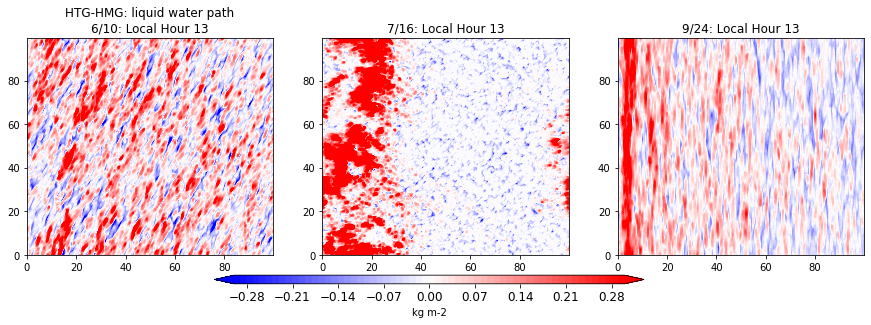

In [24]:
## Plot HTG-HMG difference per day at a selected hour 

pltVar = 'AVS_LWP'
hrSel  = 13

htg_20160610 = LES_allCasesDefault_20160610.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
hmg_20160610 = LES_allCasesDefault_20160610.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20160610['Time.hour'].values==hrSel)[0])
diff_20160610 = htg_20160610 - hmg_20160610


htg_20170716 = LES_allCasesDefault_20170716.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
hmg_20170716 = LES_allCasesDefault_20170716.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170716['Time.hour'].values==hrSel)[0])
diff_20170716 = htg_20170716 - hmg_20170716

htg_20170924 = LES_allCasesDefault_20170924.sel(case='HTG').isel(Time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
hmg_20170924 = LES_allCasesDefault_20170924.sel(case='HMG').isel(Time=np.where(LES_allCasesDefault_20170924['Time.hour'].values==hrSel)[0])
diff_20170924 = htg_20170924 - hmg_20170924


## Plot options 
fig,axs = plt.subplots(1,3, figsize=(15,4))
axs     = axs.ravel()
levsDiff = np.arange(-0.3,0.31,0.01)   ## AVS_LWP
# levsDiff = np.arange(-90,91,1)   ## AVS_SH
# levsDiff = np.arange(-2e-5, 2.05e-5, 0.05e-5)   ## AVS_RAIN


## Plot the difference 
axs[0].contourf(xvals, yvals, np.squeeze(diff_20160610[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

cplt = axs[1].contourf(xvals, yvals, np.squeeze(diff_20170716[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.1, ax_position.width+0.17, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=LES_allCasesDefault[pltVar].units)
cbar.ax.tick_params(labelsize=12) 

axs[2].contourf(xvals, yvals, np.squeeze(diff_20170924[pltVar].values), 
               levsDiff, cmap='bwr', extend='both')

## Set titles 
axs[0].set_title('HTG-HMG: '+LES_allCasesDefault[pltVar].description+'\n'+
              str(diff_20160610['Time.month'].values[0])+'/'+
              str(diff_20160610['Time.day'].values[0])+': Local Hour '+
              str(diff_20160610['Time.hour'].values[0]) )

axs[1].set_title('\n'+
              str(diff_20170716['Time.month'].values[0])+'/'+
              str(diff_20170716['Time.day'].values[0])+': Local Hour '+
              str(diff_20170716['Time.hour'].values[0]) )

axs[2].set_title('\n'+
              str(diff_20170924['Time.month'].values[0])+'/'+
              str(diff_20170924['Time.day'].values[0])+': Local Hour '+
              str(diff_20170924['Time.hour'].values[0]) )

In [31]:
def drawMap(pltVar, pltDS, testDS, ctrlDS, diffDS, levsC, levsCdiff, cmapRaw, timeSel):
    
    ## Plot raw values 
    axs[0].contourf(xvals, yvals, ctrlDS.isel(Time=timeSel).values, 
                   levsC, cmap=cmapRaw, extend='both')

    cplt = axs[1].contourf(xvals, yvals, testDS.isel(Time=timeSel).values, 
                   levsC, cmap=cmapRaw, extend='both')

    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units)
    cbar.ax.tick_params(labelsize=12) 

    axs[0].set_title(pltCaseCtrl+': '+pltDS[pltVar].description+'\n'+
                  str(pltDS['Time.month'].values[timeSel])+'/'+
                  str(pltDS['Time.day'].values[timeSel])+': Local Hour '+
                  str(pltDS['Time.hour'].values[timeSel]) )

    axs[1].set_title(pltCaseTest+': '+pltDS[pltVar].description+'\n'+
                  str(pltDS['Time.month'].values[timeSel])+'/'+
                  str(pltDS['Time.day'].values[timeSel])+': Local Hour '+
                  str(pltDS['Time.hour'].values[timeSel]) )


    ## Plot the difference 
    cplt = axs[2].contourf(xvals, yvals, diffDS.isel(Time=timeSel).values, 
                   levsCdiff, cmap='bwr', extend='both')
    # Add colorbar
    ax_position = axs[2].get_position()
    cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.05, ax_position.width+0.1, 0.03])
    cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax, label=pltDS[pltVar].units)
    cbar.ax.tick_params(labelsize=12) 

    axs[2].set_title(pltCaseTest+'-'+pltCaseCtrl+': '+pltDS[pltVar].description+'\n'+
                  str(pltDS['Time.month'].values[timeSel])+'/'+
                  str(pltDS['Time.day'].values[timeSel])+': Local Hour '+
                  str(pltDS['Time.hour'].values[timeSel]) )

    return

def animate(frame):
    return drawMap(pltVar, pltDS, testDS, ctrlDS, diffDS, levsC, levsCdiff, cmapRaw, frame)

In [63]:
# ## Options:
# pltDS       = LES_allCasesDefault_20170716
# dateString  = '20170716'

# pltDS       = LES_allCasesDefault_20170924
# dateString  = '20170924'

# pltDS       = LES_allCasesDefault_20160610
# dateString  = '20160610'

In [66]:
fig,axs = plt.subplots(1,3, figsize=(20,7))
axs     = axs.ravel()

pltVar      = 'AVS_SH'
pltDS       = LES_allCasesDefault_20170716
dateString  = '20170716'
pltCaseTest = 'HTG'
pltCaseCtrl = 'HMG' 
cmapRaw     = 'viridis'

testDS = pltDS.sel(case=pltCaseTest)[pltVar]
ctrlDS = pltDS.sel(case=pltCaseCtrl)[pltVar]

## Get levels to plot 
levsMinRaw = np.nanpercentile(pltDS[pltVar], 10)
levsMaxRaw = np.nanpercentile(pltDS[pltVar], 99)
levsC      = np.arange(levsMinRaw, levsMaxRaw, (levsMaxRaw-levsMinRaw)/100)

diffDS = testDS - ctrlDS
levsMaxDiff = np.nanpercentile(diffDS.values, 95) 
levsMinDiff = np.nanpercentile(diffDS.values, 5) 
levsEvenDiff = np.nanmax([np.abs(levsMaxDiff), np.abs(levsMinDiff)])
cstep        = (2*levsEvenDiff)/100
levsCdiff    = np.arange(-levsEvenDiff, levsEvenDiff+cstep, cstep)

frames = len(pltDS.Time.values)
ani = animation.FuncAnimation(fig, animate, frames, interval=1, blit=False,
                              repeat=False)

# ani.save('TestAnimation_HTGminusHMG_'+pltVar+'.mp4', writer=animation.FFMpegWriter(fps=8))
writergif = animation.PillowWriter(fps=1) 
ani.save('../CLASP_animations/'+pltVar+'_'+dateString+'.gif', writer=writergif)

plt.close(fig)

In [67]:
pwd

'/glade/u/home/mdfowler/Analysis/CLASP_ensOptions'

In [216]:
fig,axs = plt.subplots(1,3, figsize=(20,7))
axs     = axs.ravel()

pltVar      = 'AVS_LWP'
pltDS       = LES_allCasesDefault_20160610
dateString  = '20160610'
pltCaseTest = 'HTG'
pltCaseCtrl = 'HMG' 
cmapRaw     = 'viridis'

testDS = pltDS.sel(case=pltCaseTest)[pltVar]
ctrlDS = pltDS.sel(case=pltCaseCtrl)[pltVar]

## Get levels to plot 
levsMinRaw = np.nanpercentile(pltDS[pltVar], 10)
levsMaxRaw = np.nanpercentile(pltDS[pltVar], 99)
levsC      = np.arange(levsMinRaw, levsMaxRaw, (levsMaxRaw-levsMinRaw)/100)

diffDS = testDS - ctrlDS
levsMaxDiff = np.nanpercentile(diffDS.values, 95) 
levsMinDiff = np.nanpercentile(diffDS.values, 5) 
levsEvenDiff = np.nanmax([np.abs(levsMaxDiff), np.abs(levsMinDiff)])
cstep        = (2*levsEvenDiff)/100
levsCdiff    = np.arange(-levsEvenDiff, levsEvenDiff+cstep, cstep)

frames = len(pltDS.Time.values)
ani = animation.FuncAnimation(fig, animate, frames, interval=1, blit=False,
                              repeat=False)

# ani.save('TestAnimation_HTGminusHMG_'+pltVar+'.mp4', writer=animation.FFMpegWriter(fps=8))
writergif = animation.PillowWriter(fps=1) 
ani.save('../CLASP_animations/'+pltVar+'_'+dateString+'.gif', writer=writergif)

plt.close(fig)

## Scratch

### Looking into CLDHGH and cloud ice issue?

In [ ]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

In [ ]:
archiveDir = '/glade/scratch/mdfowler/archive/'

dateStrings = ['0609', '0923', '0715']
yearStrings = ['2016', '2017', '2017']
multiplVer  = ['V3',     'V4',   'V2']

iDay = 0
# caseHTG    = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult10_start'+dateStrings[iDay]+'_pert00/'
# caseHTGles =  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_start'+dateStrings[iDay]+yearStrings[iDay]+'/'    #LES-based multipliers

caseHTG    = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult10_start'+dateStrings[iDay]+'_pert00_take2/'
caseHTGles =  'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_start'+dateStrings[iDay]+yearStrings[iDay]+'_pert00/'    #LES-based multipliers

listFiles_htg_h0 = np.sort(glob.glob(archiveDir+caseHTG+'atm/hist/*cam.h0*'))
listFiles_htgLES_h0 = np.sort(glob.glob(archiveDir+caseHTGles+'atm/hist/*cam.h0*'))

iFile = 0
with xr.open_dataset(listFiles_htg_h0[iFile], decode_times=False) as dsHTG_h0: 
            dsHTG_h0         = cesm_correct_time(dsHTG_h0)
            dsHTG_h0['time'] = dsHTG_h0.indexes['time'].to_datetimeindex() 
            
            
with xr.open_dataset(listFiles_htgLES_h0[iFile], decode_times=False) as dsHTGles_h0: 
            dsHTGles_h0         = cesm_correct_time(dsHTGles_h0)
            dsHTGles_h0['time'] = dsHTGles_h0.indexes['time'].to_datetimeindex() 
            
            
# Compute local time 
localTimesHTG    = dsHTG_h0['time'].values - np.timedelta64(5,'h')
localTimesHTGles = dsHTGles_h0['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
dsHTG_h0    = dsHTG_h0.assign_coords({"time": localTimesHTG})
dsHTGles_h0 = dsHTGles_h0.assign_coords({"time": localTimesHTGles})

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

pltVar = 'CLDHGH'

axs.plot(dsHTG_h0.time.values, np.squeeze(dsHTG_h0[pltVar].values), 'b',label='HTG')
axs.plot(dsHTGles_h0.time.values, np.squeeze(dsHTGles_h0[pltVar].values),'r--', label='HTG*LES')
axs.legend()
axs.set_title(dsHTG_h0[pltVar].long_name)
axs.set_ylabel(dsHTG_h0[pltVar].units)
axs.set_xlim([dsHTG_h0.time.values[0], dsHTG_h0.time.values[600]])

In [ ]:
fig,axs = plt.subplots(3,1, figsize=(12,10))
axs = axs.ravel()

pltVar = 'CLOUD'

## Plot HTG 
c =  axs[0].contourf(dsHTG_h0.time.values[0:600], dsHTG_h0.lev.values, 
             np.squeeze(dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50)
axs[0].invert_yaxis()
axs[0].set_title('HTG: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES
c =  axs[1].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50)
axs[1].invert_yaxis()
axs[1].set_title('HTG*LES: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES - HTG
c =  axs[2].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values - 
                       dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(),
                    cmap='bwr')
axs[2].invert_yaxis()
axs[2].set_title('HTG*LES - HTG: '+pltVar)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

pltVar = 'TGCLDLWP'

axs.plot(dsHTG_h0.time.values, np.squeeze(dsHTG_h0[pltVar].values), 'b',label='HTG')
axs.plot(dsHTGles_h0.time.values, np.squeeze(dsHTGles_h0[pltVar].values),'r--', label='HTG*LES')
axs.legend()
axs.set_title(dsHTG_h0[pltVar].long_name)
axs.set_ylabel(dsHTG_h0[pltVar].units)
axs.set_xlim([dsHTG_h0.time.values[0], dsHTG_h0.time.values[600]])
# axs.set_ylim([0,0.06])

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(15,5))

pltVar = 'TGCLDIWP'

axs.plot(dsHTG_h0.time.values, np.squeeze(dsHTG_h0[pltVar].values), 'b',label='HTG')
axs.plot(dsHTGles_h0.time.values, np.squeeze(dsHTGles_h0[pltVar].values),'r--', label='HTG*LES')
axs.legend()
axs.set_title(dsHTG_h0[pltVar].long_name)
axs.set_ylabel(dsHTG_h0[pltVar].units)
axs.set_xlim([dsHTG_h0.time.values[0], dsHTG_h0.time.values[600]])
# axs.set_ylim([0,0.06])

In [ ]:
fig,axs = plt.subplots(3,1, figsize=(12,10))
axs = axs.ravel()

pltVar = 'Q'

## Plot HTG 
c =  axs[0].contourf(dsHTG_h0.time.values[0:600], dsHTG_h0.lev.values, 
             np.squeeze(dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50)
axs[0].invert_yaxis()
axs[0].set_title('HTG: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES
c =  axs[1].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50)
axs[1].invert_yaxis()
axs[1].set_title('HTG*LES: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES - HTG
c =  axs[2].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values - 
                       dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(),
                       np.arange(-0.00008, 0.000081, 0.000001), cmap='bwr')
axs[2].invert_yaxis()
axs[2].set_title('HTG*LES - HTG: '+pltVar)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

In [ ]:
fig,axs = plt.subplots(3,1, figsize=(12,10))
axs = axs.ravel()

pltVar = 'T'

## Plot HTG 
c =  axs[0].contourf(dsHTG_h0.time.values[0:600], dsHTG_h0.lev.values, 
             np.squeeze(dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50)
axs[0].invert_yaxis()
axs[0].set_title('HTG: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES
c =  axs[1].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50)
axs[1].invert_yaxis()
axs[1].set_title('HTG*LES: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES - HTG
c =  axs[2].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values - 
                       dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(),
                       np.arange(-0.3, 0.31, 0.01), cmap='bwr')
axs[2].invert_yaxis()
axs[2].set_title('HTG*LES - HTG: '+pltVar)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

In [ ]:
fig,axs = plt.subplots(3,1, figsize=(12,10))
axs = axs.ravel()

pltVar = 'WSUB'

## Plot HTG 
c =  axs[0].contourf(dsHTG_h0.time.values[0:600], dsHTG_h0.lev.values, 
             np.squeeze(dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50,
                    cmap='jet')
axs[0].invert_yaxis()
axs[0].set_title('HTG: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical', label=dsHTG_h0[pltVar].units)

## Plot HTG*LES
c =  axs[1].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(), 50,
                    cmap = 'jet')
axs[1].invert_yaxis()
axs[1].set_title('HTG*LES: '+dsHTG_h0[pltVar].long_name)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

## Plot HTG*LES - HTG
c =  axs[2].contourf(dsHTGles_h0.time.values[0:600], dsHTGles_h0.lev.values, 
             np.squeeze(dsHTGles_h0[pltVar].isel(time=np.arange(0,600)).values - 
                       dsHTG_h0[pltVar].isel(time=np.arange(0,600)).values).transpose(),
                       np.arange(-0.05, 0.051, 0.001), cmap='bwr',extend='both')
axs[2].invert_yaxis()
axs[2].set_title('HTG*LES - HTG: '+pltVar)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')